# Análisis Exploratorio de Datos (EDA) - Tabla: historial_pagos

## Objetivo

Realizar un análisis exploratorio completo de la tabla `historial_pagos` para:
- Explorar la estructura y contenido de los datos
- Detectar valores nulos, duplicados, atípicos e inconsistencias
- Analizar campo numérico (monto) y detectar outliers
- Analizar campo temporal (fecha_pago) para identificar tendencias y patrones
- Analizar campo ENUM (estado_pago) para verificar valores válidos
- Verificar consistencia entre montos de pagos y totales de órdenes
- Identificar claves primarias y foráneas implícitas
- Analizar campos semi-estructurados
- Proponer acciones de preprocesamiento y corrección de calidad de datos
- Generar reporte de hallazgos y decisiones tomadas


## 1. Configuración Inicial e Importaciones


In [1]:
# Importar bibliotecas necesarias
import sys
import os

try:
    from ...Utils.path_manager import PathManager
except ImportError:
    # Si falla el import relativo 
    current_dir = os.getcwd()  # Directorio actual de trabajo
    if 'Notebooks' in current_dir:
        avance1_dir = os.path.dirname(os.path.dirname(current_dir))
    else:
        # Intentar calcular desde la ubicación relativa
        avance1_dir = os.path.abspath(os.path.join(current_dir, '..', '..'))
    
    utils_dir = os.path.join(avance1_dir, 'Utils')
    if utils_dir not in sys.path:
        sys.path.insert(0, utils_dir)
    from path_manager import PathManager

# Configurar sys.path usando PathManager (patrón Singleton)
path_manager = PathManager.get_instance()
path_manager.setup_sys_path()

# Importar DBConnector desde la raíz del proyecto
from Database.db_connector import DBConnector

# Importar bibliotecas de análisis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
try:
    plt.style.use('seaborn-v0_8-darkgrid')
except:
    plt.style.use('seaborn-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("✓ Bibliotecas importadas correctamente")


✓ Bibliotecas importadas correctamente


In [2]:
# Obtener el Engine de la base de datos usando DBConnector (patrón Singleton)
db = DBConnector.get_instance()
engine = db.get_engine()

print("✓ Conexión a la base de datos establecida")
print(f"✓ Engine obtenido: {type(engine).__name__}")


✓ Conexión a la base de datos establecida
✓ Engine obtenido: Engine


## 2. Exploración de Estructura y Contenido con SQL


### 2.1. Estructura de la Tabla (Schema)


In [3]:
# Consulta SQL para obtener la estructura de la tabla
query_schema = """
SELECT 
    column_name,
    data_type,
    character_maximum_length,
    numeric_precision,
    numeric_scale,
    is_nullable,
    column_default
FROM information_schema.columns
WHERE table_schema = 'public' 
    AND table_name = 'historial_pagos'
ORDER BY ordinal_position;
"""

df_schema = pd.read_sql(query_schema, engine)

print("=" * 80)
print("ESTRUCTURA DE LA TABLA: historial_pagos")
print("=" * 80)
print(df_schema.to_string(index=False))


ESTRUCTURA DE LA TABLA: historial_pagos
   column_name                   data_type character_maximum_length  numeric_precision  numeric_scale is_nullable                                   column_default
       pago_id                     integer                     None               32.0            0.0          NO nextval('historial_pagos_pago_id_seq'::regclass)
      orden_id                     integer                     None               32.0            0.0         YES                                             None
metodo_pago_id                     integer                     None               32.0            0.0         YES                                             None
         monto                     numeric                     None               10.0            2.0          NO                                             None
    fecha_pago timestamp without time zone                     None                NaN            NaN         YES                                

### 2.2. Restricciones y Claves (Constraints)


In [4]:
# Consulta SQL para obtener restricciones de la tabla
query_constraints = """
SELECT
    tc.constraint_name,
    tc.constraint_type,
    kcu.column_name,
    ccu.table_name AS foreign_table_name,
    ccu.column_name AS foreign_column_name
FROM information_schema.table_constraints AS tc
JOIN information_schema.key_column_usage AS kcu
    ON tc.constraint_name = kcu.constraint_name
    AND tc.table_schema = kcu.table_schema
LEFT JOIN information_schema.constraint_column_usage AS ccu
    ON ccu.constraint_name = tc.constraint_name
    AND ccu.table_schema = tc.table_schema
WHERE tc.table_schema = 'public'
    AND tc.table_name = 'historial_pagos'
ORDER BY tc.constraint_type, tc.constraint_name;
"""

df_constraints = pd.read_sql(query_constraints, engine)

print("=" * 80)
print("RESTRICCIONES Y CLAVES DE LA TABLA: historial_pagos")
print("=" * 80)
if not df_constraints.empty:
    print(df_constraints.to_string(index=False))
else:
    print("No se encontraron restricciones explícitas.")

# Consulta adicional para obtener CHECK constraints
query_check = """
SELECT
    conname AS constraint_name,
    pg_get_constraintdef(oid) AS constraint_definition
FROM pg_constraint
WHERE conrelid = 'historial_pagos'::regclass
    AND contype = 'c';
"""

df_check = pd.read_sql(query_check, engine)

if not df_check.empty:
    print("\n" + "=" * 80)
    print("CHECK CONSTRAINTS")
    print("=" * 80)
    print(df_check.to_string(index=False))

# Consulta para obtener valores del ENUM estado_pago
query_enum = """
SELECT 
    t.typname AS enum_name,
    e.enumlabel AS enum_value
FROM pg_type t 
JOIN pg_enum e ON t.oid = e.enumtypid  
WHERE t.typname = 'estado_pago'
ORDER BY e.enumsortorder;
"""

df_enum = pd.read_sql(query_enum, engine)

if not df_enum.empty:
    print("\n" + "=" * 80)
    print("VALORES DEL ENUM estado_pago")
    print("=" * 80)
    print(df_enum.to_string(index=False))


RESTRICCIONES Y CLAVES DE LA TABLA: historial_pagos
                    constraint_name constraint_type    column_name foreign_table_name foreign_column_name
historial_pagos_metodo_pago_id_fkey     FOREIGN KEY metodo_pago_id       metodos_pago      metodo_pago_id
      historial_pagos_orden_id_fkey     FOREIGN KEY       orden_id            ordenes            orden_id
               historial_pagos_pkey     PRIMARY KEY        pago_id    historial_pagos             pago_id

CHECK CONSTRAINTS
     constraint_name           constraint_definition
check_monto_positivo CHECK ((monto >= (0)::numeric))

VALORES DEL ENUM estado_pago
  enum_name  enum_value
estado_pago  Procesando
estado_pago      Pagado
estado_pago     Fallido
estado_pago Reembolsado


In [5]:
# Consultas SQL para estadísticas básicas
query_stats = """
SELECT 
    COUNT(*) as total_pagos,
    COUNT(DISTINCT pago_id) as pagos_unicos,
    COUNT(DISTINCT orden_id) as ordenes_distintas,
    COUNT(DISTINCT metodo_pago_id) as metodos_pago_distintos,
    COUNT(monto) as montos_no_nulos,
    MIN(monto) as monto_minimo,
    MAX(monto) as monto_maximo,
    AVG(monto) as monto_promedio,
    SUM(monto) as monto_total,
    MIN(fecha_pago) as fecha_pago_mas_antigua,
    MAX(fecha_pago) as fecha_pago_mas_reciente
FROM historial_pagos;
"""

df_stats = pd.read_sql(query_stats, engine)

print("=" * 80)
print("ESTADÍSTICAS BÁSICAS DE LA TABLA: historial_pagos")
print("=" * 80)
print(df_stats.to_string(index=False))

# Distribución por estado_pago
query_distribucion_estado = """
SELECT 
    estado_pago,
    COUNT(*) as cantidad,
    ROUND(COUNT(*) * 100.0 / (SELECT COUNT(*) FROM historial_pagos), 2) as porcentaje,
    SUM(monto) as monto_total,
    AVG(monto) as monto_promedio
FROM historial_pagos
GROUP BY estado_pago
ORDER BY cantidad DESC;
"""

df_distribucion_estado = pd.read_sql(query_distribucion_estado, engine)

print("\n" + "=" * 80)
print("DISTRIBUCIÓN POR ESTADO DE PAGO")
print("=" * 80)
print(df_distribucion_estado.to_string(index=False))

# Top 10 órdenes por número de pagos
query_top_ordenes = """
SELECT 
    orden_id,
    COUNT(*) as cantidad_pagos,
    SUM(monto) as monto_total_pagado,
    COUNT(DISTINCT estado_pago) as estados_distintos
FROM historial_pagos
GROUP BY orden_id
ORDER BY cantidad_pagos DESC
LIMIT 10;
"""

df_top_ordenes = pd.read_sql(query_top_ordenes, engine)

print("\n" + "=" * 80)
print("TOP 10 ÓRDENES POR NÚMERO DE PAGOS")
print("=" * 80)
print(df_top_ordenes.to_string(index=False))

# Distribución por método de pago
query_distribucion_metodo = """
SELECT 
    metodo_pago_id,
    COUNT(*) as veces_usado,
    SUM(monto) as monto_total,
    AVG(monto) as monto_promedio,
    COUNT(DISTINCT estado_pago) as estados_distintos
FROM historial_pagos
GROUP BY metodo_pago_id
ORDER BY veces_usado DESC;
"""

df_distribucion_metodo = pd.read_sql(query_distribucion_metodo, engine)

print("\n" + "=" * 80)
print("DISTRIBUCIÓN POR MÉTODO DE PAGO")
print("=" * 80)
print(df_distribucion_metodo.to_string(index=False))


ESTADÍSTICAS BÁSICAS DE LA TABLA: historial_pagos
 total_pagos  pagos_unicos  ordenes_distintas  metodos_pago_distintos  montos_no_nulos  monto_minimo  monto_maximo  monto_promedio  monto_total fecha_pago_mas_antigua fecha_pago_mas_reciente
       10000         10000              10000                       7            10000        100.03        999.73      551.020499   5510204.99    2025-04-01 10:19:16     2025-06-30 10:19:16

DISTRIBUCIÓN POR ESTADO DE PAGO
estado_pago  cantidad  porcentaje  monto_total  monto_promedio
    Fallido      2546       25.46   1391194.04      546.423425
 Procesando      2542       25.42   1398880.67      550.307109
     Pagado      2457       24.57   1353919.11      551.045629
Reembolsado      2455       24.55   1366211.17      556.501495

TOP 10 ÓRDENES POR NÚMERO DE PAGOS
 orden_id  cantidad_pagos  monto_total_pagado  estados_distintos
        2               1              647.98                  1
        3               1              627.45         

In [6]:
# Cargar la tabla completa en un DataFrame
query_historial = "SELECT * FROM historial_pagos;"
df_historial = pd.read_sql(query_historial, engine)

# Convertir fecha_pago a datetime si no está ya en ese formato
if 'fecha_pago' in df_historial.columns:
    df_historial['fecha_pago'] = pd.to_datetime(df_historial['fecha_pago'])

print("=" * 80)
print("CARGA DE DATOS COMPLETA")
print("=" * 80)
print(f"Forma del DataFrame: {df_historial.shape}")
print(f"Columnas: {list(df_historial.columns)}")
print(f"\nPrimeras 10 filas:")
print(df_historial.head(10))


CARGA DE DATOS COMPLETA
Forma del DataFrame: (10000, 6)
Columnas: ['pago_id', 'orden_id', 'metodo_pago_id', 'monto', 'fecha_pago', 'estado_pago']

Primeras 10 filas:
   pago_id  orden_id  metodo_pago_id   monto          fecha_pago  estado_pago
0        1         1               4  147.13 2025-06-02 10:19:16   Procesando
1        2         2               1  647.98 2025-04-27 10:19:16  Reembolsado
2        3         3               6  627.45 2025-05-07 10:19:16      Fallido
3        4         4               5  848.07 2025-06-30 10:19:16   Procesando
4        5         5               5  189.80 2025-04-03 10:19:16      Fallido
5        6         6               2  153.09 2025-06-11 10:19:16       Pagado
6        7         7               5  715.68 2025-04-23 10:19:16      Fallido
7        8         8               2  377.24 2025-05-03 10:19:16       Pagado
8        9         9               5  883.24 2025-04-03 10:19:16       Pagado
9       10        10               4  515.29 2025-05-1

### 3.1. Información General del DataFrame


In [7]:
# Información detallada del DataFrame
print("=" * 80)
print("INFORMACIÓN GENERAL DEL DATAFRAME")
print("=" * 80)
df_historial.info()
print("\n" + "=" * 80)
print("TIPOS DE DATOS POR COLUMNA")
print("=" * 80)
print(df_historial.dtypes)
print("\n" + "=" * 80)
print("ESTADÍSTICAS DESCRIPTIVAS")
print("=" * 80)
print(df_historial.describe(include='all'))


INFORMACIÓN GENERAL DEL DATAFRAME
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   pago_id         10000 non-null  int64         
 1   orden_id        10000 non-null  int64         
 2   metodo_pago_id  10000 non-null  int64         
 3   monto           10000 non-null  float64       
 4   fecha_pago      10000 non-null  datetime64[ns]
 5   estado_pago     10000 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 468.9+ KB

TIPOS DE DATOS POR COLUMNA
pago_id                    int64
orden_id                   int64
metodo_pago_id             int64
monto                    float64
fecha_pago        datetime64[ns]
estado_pago               object
dtype: object

ESTADÍSTICAS DESCRIPTIVAS
            pago_id     orden_id  metodo_pago_id         monto  \
count   10000.00000  10000.

### 3.2. Detección de Valores Nulos


In [8]:
# Análisis de valores nulos
print("=" * 80)
print("ANÁLISIS DE VALORES NULOS")
print("=" * 80)

nulos_por_columna = df_historial.isnull().sum()
porcentaje_nulos = (df_historial.isnull().sum() / len(df_historial)) * 100

df_nulos = pd.DataFrame({
    'Columna': nulos_por_columna.index,
    'Cantidad_Nulos': nulos_por_columna.values,
    'Porcentaje_Nulos': porcentaje_nulos.values
})

print(df_nulos.to_string(index=False))

# Verificar si hay valores nulos en total
total_nulos = df_historial.isnull().sum().sum()
print(f"\nTotal de valores nulos en toda la tabla: {total_nulos}")

if total_nulos == 0:
    print("✓ No se encontraron valores nulos en la tabla.")
else:
    print("⚠ ADVERTENCIA: Se encontraron valores nulos que requieren atención.")
    print("\nAnálisis de valores nulos por columna:")
    for col in df_historial.columns:
        nulos_col = df_historial[col].isnull().sum()
        if nulos_col > 0:
            print(f"  - {col}: {nulos_col} valores nulos ({nulos_col/len(df_historial)*100:.1f}%)")
            # Verificar si el campo es obligatorio
            if col in ['orden_id', 'metodo_pago_id', 'monto']:
                print(f"    ⚠ CRÍTICO: Campo obligatorio con valores nulos")


ANÁLISIS DE VALORES NULOS
       Columna  Cantidad_Nulos  Porcentaje_Nulos
       pago_id               0               0.0
      orden_id               0               0.0
metodo_pago_id               0               0.0
         monto               0               0.0
    fecha_pago               0               0.0
   estado_pago               0               0.0

Total de valores nulos en toda la tabla: 0
✓ No se encontraron valores nulos en la tabla.


### 3.3. Detección de Duplicados


In [9]:
# Análisis de duplicados
print("=" * 80)
print("ANÁLISIS DE DUPLICADOS")
print("=" * 80)

# Duplicados completos (todas las columnas)
duplicados_completos = df_historial.duplicated().sum()
print(f"Registros completamente duplicados: {duplicados_completos}")

# Duplicados por pago_id (clave primaria)
duplicados_pago_id = df_historial['pago_id'].duplicated().sum()
print(f"Duplicados en pago_id (PK): {duplicados_pago_id}")

# Duplicados por combinación orden_id + metodo_pago_id (puede ser válido si una orden tiene múltiples pagos)
duplicados_orden_metodo = df_historial.duplicated(subset=['orden_id', 'metodo_pago_id']).sum()
print(f"Duplicados en combinación (orden_id, metodo_pago_id): {duplicados_orden_metodo}")

# Mostrar duplicados si existen
if duplicados_completos > 0:
    print("\n⚠ ADVERTENCIA: Se encontraron registros completamente duplicados:")
    duplicados = df_historial[df_historial.duplicated(keep=False)]
    print(duplicados.sort_values('pago_id'))

if duplicados_orden_metodo > 0:
    print("\n⚠ ADVERTENCIA: Se encontraron múltiples pagos para la misma combinación (orden_id, metodo_pago_id):")
    duplicados_om = df_historial[df_historial.duplicated(subset=['orden_id', 'metodo_pago_id'], keep=False)]
    print(f"Total de registros duplicados: {len(duplicados_om)}")
    print("\nNota: Esto puede ser válido si una orden tiene múltiples pagos con el mismo método,")
    print("pero podría indicar un problema de diseño si se espera una única entrada por orden-método.")
    print(duplicados_om.sort_values(['orden_id', 'metodo_pago_id', 'fecha_pago']).head(20))

if duplicados_completos == 0 and duplicados_pago_id == 0:
    print("\n✓ No se encontraron duplicados completos en la tabla.")


ANÁLISIS DE DUPLICADOS
Registros completamente duplicados: 0
Duplicados en pago_id (PK): 0
Duplicados en combinación (orden_id, metodo_pago_id): 0

✓ No se encontraron duplicados completos en la tabla.


### 3.4. Análisis de Campo Numérico (monto)


In [10]:
# Análisis del campo monto
print("=" * 80)
print("ANÁLISIS DEL CAMPO: monto")
print("=" * 80)

monto = df_historial['monto']

print(f"\nEstadísticas Descriptivas:")
print(f"  - Mínimo: {monto.min():.2f}")
print(f"  - Máximo: {monto.max():.2f}")
print(f"  - Media: {monto.mean():.2f}")
print(f"  - Mediana: {monto.median():.2f}")
print(f"  - Desviación estándar: {monto.std():.2f}")
print(f"  - Q1 (25%): {monto.quantile(0.25):.2f}")
print(f"  - Q3 (75%): {monto.quantile(0.75):.2f}")
print(f"  - IQR: {monto.quantile(0.75) - monto.quantile(0.25):.2f}")

# Valores negativos
valores_negativos = (monto < 0).sum()
print(f"\nValores negativos: {valores_negativos}")
if valores_negativos > 0:
    print("⚠ ADVERTENCIA: Se encontraron valores negativos que violan el CHECK constraint")
    print(df_historial[monto < 0][['pago_id', 'orden_id', 'metodo_pago_id', 'monto', 'estado_pago']])

# Valores cero
valores_cero = (monto == 0).sum()
print(f"\nValores cero: {valores_cero}")
if valores_cero > 0:
    print("⚠ ADVERTENCIA: Se encontraron valores cero (montos de pago de 0)")
    print(df_historial[monto == 0][['pago_id', 'orden_id', 'metodo_pago_id', 'monto', 'estado_pago']].head(10))

# Detección de outliers usando IQR
Q1 = monto.quantile(0.25)
Q3 = monto.quantile(0.75)
IQR = Q3 - Q1
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

outliers = monto[(monto < limite_inferior) | (monto > limite_superior)]
print(f"\nOutliers detectados (método IQR): {len(outliers)}")
print(f"  - Límite inferior: {max(0, limite_inferior):.2f} (ajustado a 0 por ser monto)")
print(f"  - Límite superior: {limite_superior:.2f}")

if len(outliers) > 0:
    print(f"\nDistribución de outliers:")
    print(outliers.value_counts().head(10))
    print(f"\nEjemplos de registros con outliers:")
    print(df_historial[monto.isin(outliers)][['pago_id', 'orden_id', 'metodo_pago_id', 'monto', 'estado_pago']].head(10))


ANÁLISIS DEL CAMPO: monto

Estadísticas Descriptivas:
  - Mínimo: 100.03
  - Máximo: 999.73
  - Media: 551.02
  - Mediana: 549.00
  - Desviación estándar: 260.46
  - Q1 (25%): 328.21
  - Q3 (75%): 779.44
  - IQR: 451.23

Valores negativos: 0

Valores cero: 0

Outliers detectados (método IQR): 0
  - Límite inferior: 0.00 (ajustado a 0 por ser monto)
  - Límite superior: 1456.28


### 3.5. Análisis de Campo ENUM (estado_pago)


In [11]:
# Análisis del campo estado_pago
print("=" * 80)
print("ANÁLISIS DEL CAMPO: estado_pago")
print("=" * 80)

estado_pago = df_historial['estado_pago']

# Valores válidos del ENUM (según el diccionario de datos)
valores_validos = ['Procesando', 'Pagado', 'Fallido', 'Reembolsado']

print(f"\nEstadísticas Generales:")
print(f"  - Total de registros: {len(estado_pago)}")
print(f"  - Valores no nulos: {estado_pago.notna().sum()}")
print(f"  - Valores nulos: {estado_pago.isnull().sum()}")

# Distribución de valores
print(f"\nDistribución de Estados de Pago:")
distribucion = estado_pago.value_counts()
for estado, cantidad in distribucion.items():
    porcentaje = (cantidad / len(estado_pago)) * 100
    print(f"  - {estado}: {cantidad} ({porcentaje:.1f}%)")

# Verificar valores inválidos (que no están en el ENUM)
valores_unicos = estado_pago.unique()
valores_invalidos = [v for v in valores_unicos if pd.notna(v) and str(v) not in valores_validos]

if len(valores_invalidos) > 0:
    print(f"\n⚠ ADVERTENCIA: Se encontraron valores inválidos en estado_pago:")
    for valor in valores_invalidos:
        cantidad = (estado_pago == valor).sum()
        print(f"  - '{valor}': {cantidad} registros")
        print(df_historial[estado_pago == valor][['pago_id', 'orden_id', 'monto', 'estado_pago']].head(10))
else:
    print(f"\n✓ Todos los valores de estado_pago son válidos según el ENUM.")

# Análisis de montos por estado
print(f"\nAnálisis de Montos por Estado:")
for estado in valores_validos:
    if estado in estado_pago.values:
        montos_estado = df_historial[estado_pago == estado]['monto']
        print(f"  - {estado}:")
        print(f"    - Cantidad: {len(montos_estado)}")
        print(f"    - Monto total: {montos_estado.sum():.2f}")
        print(f"    - Monto promedio: {montos_estado.mean():.2f}")
        print(f"    - Monto mínimo: {montos_estado.min():.2f}")
        print(f"    - Monto máximo: {montos_estado.max():.2f}")


ANÁLISIS DEL CAMPO: estado_pago

Estadísticas Generales:
  - Total de registros: 10000
  - Valores no nulos: 10000
  - Valores nulos: 0

Distribución de Estados de Pago:
  - Fallido: 2546 (25.5%)
  - Procesando: 2542 (25.4%)
  - Pagado: 2457 (24.6%)
  - Reembolsado: 2455 (24.6%)

✓ Todos los valores de estado_pago son válidos según el ENUM.

Análisis de Montos por Estado:
  - Procesando:
    - Cantidad: 2542
    - Monto total: 1398880.67
    - Monto promedio: 550.31
    - Monto mínimo: 100.28
    - Monto máximo: 999.57
  - Pagado:
    - Cantidad: 2457
    - Monto total: 1353919.11
    - Monto promedio: 551.05
    - Monto mínimo: 100.17
    - Monto máximo: 999.65
  - Fallido:
    - Cantidad: 2546
    - Monto total: 1391194.04
    - Monto promedio: 546.42
    - Monto mínimo: 100.14
    - Monto máximo: 998.70
  - Reembolsado:
    - Cantidad: 2455
    - Monto total: 1366211.17
    - Monto promedio: 556.50
    - Monto mínimo: 100.03
    - Monto máximo: 999.73


### 3.6. Análisis Temporal del Campo fecha_pago


In [12]:
# Análisis del campo fecha_pago
print("=" * 80)
print("ANÁLISIS DEL CAMPO: fecha_pago")
print("=" * 80)

fechas = df_historial['fecha_pago'].dropna()

if len(fechas) > 0:
    print(f"\nEstadísticas Temporales:")
    print(f"  - Fecha más antigua: {fechas.min()}")
    print(f"  - Fecha más reciente: {fechas.max()}")
    print(f"  - Rango temporal: {(fechas.max() - fechas.min()).days} días")
    print(f"  - Total de fechas no nulas: {len(fechas)}")
    
    # Fechas nulas
    fechas_nulas = df_historial['fecha_pago'].isnull().sum()
    print(f"  - Fechas nulas: {fechas_nulas}")
    if fechas_nulas > 0:
        print("⚠ ADVERTENCIA: Se encontraron fechas nulas")
        print(df_historial[df_historial['fecha_pago'].isnull()][['pago_id', 'orden_id', 'monto', 'estado_pago']].head(10))
    
    # Fechas futuras (anomalías)
    fecha_actual = pd.Timestamp.now()
    fechas_futuras = fechas[fechas > fecha_actual]
    print(f"\nFechas futuras (anomalías): {len(fechas_futuras)}")
    if len(fechas_futuras) > 0:
        print("⚠ ADVERTENCIA: Se encontraron fechas futuras")
        print(df_historial[df_historial['fecha_pago'].isin(fechas_futuras)][['pago_id', 'orden_id', 'monto', 'fecha_pago', 'estado_pago']].head(10))
    
    # Fechas muy antiguas (más de 10 años)
    fecha_limite_antigua = fecha_actual - pd.Timedelta(days=3650)  # 10 años
    fechas_antiguas = fechas[fechas < fecha_limite_antigua]
    print(f"\nFechas muy antiguas (> 10 años): {len(fechas_antiguas)}")
    if len(fechas_antiguas) > 0:
        print("⚠ ADVERTENCIA: Se encontraron fechas muy antiguas")
        print(df_historial[df_historial['fecha_pago'].isin(fechas_antiguas)][['pago_id', 'orden_id', 'monto', 'fecha_pago', 'estado_pago']].head(10))
    
    # Distribución por año
    print(f"\nDistribución de Pagos por Año:")
    distribucion_anio = fechas.dt.year.value_counts().sort_index()
    for anio, cantidad in distribucion_anio.items():
        print(f"  - {anio}: {cantidad} pagos")
    
    # Distribución por mes (último año)
    fecha_ultimo_anio = fecha_actual - pd.Timedelta(days=365)
    fechas_ultimo_anio = fechas[fechas >= fecha_ultimo_anio]
    if len(fechas_ultimo_anio) > 0:
        print(f"\nDistribución de Pagos por Mes (último año):")
        distribucion_mes = fechas_ultimo_anio.dt.month.value_counts().sort_index()
        meses = ['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic']
        for mes, cantidad in distribucion_mes.items():
            print(f"  - {meses[mes-1]}: {cantidad} pagos")
    
    # Distribución por día de la semana
    print(f"\nDistribución de Pagos por Día de la Semana:")
    distribucion_dia = fechas.dt.day_name().value_counts()
    dias_orden = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    dias_esp = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']
    for dia_eng, dia_esp in zip(dias_orden, dias_esp):
        if dia_eng in distribucion_dia.index:
            cantidad = distribucion_dia[dia_eng]
            print(f"  - {dia_esp}: {cantidad} pagos")
else:
    print("⚠ ADVERTENCIA: No se encontraron fechas válidas en la tabla.")


ANÁLISIS DEL CAMPO: fecha_pago

Estadísticas Temporales:
  - Fecha más antigua: 2025-04-01 10:19:16
  - Fecha más reciente: 2025-06-30 10:19:16
  - Rango temporal: 90 días
  - Total de fechas no nulas: 10000
  - Fechas nulas: 0

Fechas futuras (anomalías): 0

Fechas muy antiguas (> 10 años): 0

Distribución de Pagos por Año:
  - 2025: 10000 pagos

Distribución de Pagos por Mes (último año):
  - Abr: 3278 pagos
  - May: 3465 pagos
  - Jun: 3257 pagos

Distribución de Pagos por Día de la Semana:
  - Lunes: 1428 pagos
  - Martes: 1410 pagos
  - Miércoles: 1371 pagos
  - Jueves: 1423 pagos
  - Viernes: 1446 pagos
  - Sábado: 1414 pagos
  - Domingo: 1508 pagos


### 3.7. Verificación de Consistencia con Totales de Órdenes


In [13]:
# Verificación de consistencia con totales de órdenes
print("=" * 80)
print("VERIFICACIÓN DE CONSISTENCIA CON TOTALES DE ÓRDENES")
print("=" * 80)

# Calcular suma de montos pagados por orden
df_suma_montos = df_historial.groupby('orden_id')['monto'].sum().reset_index()
df_suma_montos.columns = ['orden_id', 'suma_montos_pagados']

# Cargar totales de órdenes
query_ordenes = "SELECT orden_id, total FROM ordenes;"
df_ordenes = pd.read_sql(query_ordenes, engine)

# Merge para comparar
df_comparacion = df_suma_montos.merge(df_ordenes, on='orden_id', how='outer')

# Identificar inconsistencias (tolerancia de 0.01 para diferencias de redondeo)
df_comparacion['diferencia'] = abs(df_comparacion['suma_montos_pagados'] - df_comparacion['total'])
df_comparacion['es_consistente'] = df_comparacion['diferencia'] <= 0.01

inconsistencias = df_comparacion[~df_comparacion['es_consistente']]

print(f"\nTotal de órdenes: {len(df_ordenes)}")
print(f"Órdenes con pagos registrados: {len(df_suma_montos)}")
print(f"Órdenes sin pagos: {len(df_ordenes) - len(df_suma_montos)}")
print(f"Inconsistencias detectadas: {len(inconsistencias)}")

if len(inconsistencias) > 0:
    print("\n⚠ ADVERTENCIA: Se encontraron inconsistencias entre la suma de montos pagados y el total de la orden:")
    print(inconsistencias[['orden_id', 'suma_montos_pagados', 'total', 'diferencia']].head(20))
else:
    print("\n✓ No se encontraron inconsistencias. La suma de montos pagados coincide con el total de las órdenes.")

# Órdenes sin pagos registrados
ordenes_sin_pagos = df_ordenes[~df_ordenes['orden_id'].isin(df_suma_montos['orden_id'])]
if len(ordenes_sin_pagos) > 0:
    print(f"\n⚠ ADVERTENCIA: Se encontraron {len(ordenes_sin_pagos)} órdenes sin pagos registrados:")
    print(ordenes_sin_pagos[['orden_id', 'total']].head(10))


VERIFICACIÓN DE CONSISTENCIA CON TOTALES DE ÓRDENES

Total de órdenes: 10000
Órdenes con pagos registrados: 10000
Órdenes sin pagos: 0
Inconsistencias detectadas: 10000

⚠ ADVERTENCIA: Se encontraron inconsistencias entre la suma de montos pagados y el total de la orden:
    orden_id  suma_montos_pagados     total  diferencia
0          1               147.13   7616.92     7469.79
1          2               647.98   5947.39     5299.41
2          3               627.45   6215.59     5588.14
3          4               848.07   4389.87     3541.80
4          5               189.80   8351.20     8161.40
5          6               153.09   4596.97     4443.88
6          7               715.68   7305.09     6589.41
7          8               377.24   5127.44     4750.20
8          9               883.24   5291.19     4407.95
9         10               515.29   9019.43     8504.14
10        11               377.24   9876.04     9498.80
11        12               493.06  11937.67    11444.61


### 3.8. Análisis de Relaciones con Órdenes y Métodos de Pago


In [14]:
# Análisis de relaciones
print("=" * 80)
print("ANÁLISIS DE RELACIONES CON ÓRDENES Y MÉTODOS DE PAGO")
print("=" * 80)

# Verificar valores nulos en foreign keys
orden_id_nulos = df_historial['orden_id'].isnull().sum()
metodo_pago_id_nulos = df_historial['metodo_pago_id'].isnull().sum()

print(f"\nValores nulos en foreign keys:")
print(f"  - orden_id nulos: {orden_id_nulos}")
print(f"  - metodo_pago_id nulos: {metodo_pago_id_nulos}")

# Distribución por orden
print(f"\nDistribución de pagos por orden:")
distribucion_orden = df_historial['orden_id'].value_counts()
print(f"  - Órdenes distintas con pagos: {distribucion_orden.nunique()}")
print(f"  - Promedio de pagos por orden: {distribucion_orden.mean():.2f}")
print(f"  - Máximo de pagos por orden: {distribucion_orden.max()}")
print(f"  - Mínimo de pagos por orden: {distribucion_orden.min()}")

# Distribución por método de pago
print(f"\nDistribución de uso por método de pago:")
distribucion_metodo = df_historial['metodo_pago_id'].value_counts()
print(f"  - Métodos de pago distintos utilizados: {distribucion_metodo.nunique()}")
print(f"  - Promedio de veces que un método es usado: {distribucion_metodo.mean():.2f}")
print(f"  - Máximo de veces que un método es usado: {distribucion_metodo.max()}")
print(f"  - Mínimo de veces que un método es usado: {distribucion_metodo.min()}")

# Verificar referencias huérfanas (orden_id que no existe en ordenes)
query_orphan_orden = """
SELECT COUNT(*) as huérfanas
FROM historial_pagos hp
LEFT JOIN ordenes o ON hp.orden_id = o.orden_id
WHERE hp.orden_id IS NOT NULL AND o.orden_id IS NULL;
"""

df_orphan_orden = pd.read_sql(query_orphan_orden, engine)
huérfanas_orden = df_orphan_orden['huérfanas'].iloc[0]

if huérfanas_orden > 0:
    print(f"\n⚠ ADVERTENCIA: Se encontraron {huérfanas_orden} referencias huérfanas (orden_id que no existe en ordenes)")
    query_orphan_orden_detalle = """
    SELECT hp.pago_id, hp.orden_id, hp.metodo_pago_id, hp.monto, hp.estado_pago
    FROM historial_pagos hp
    LEFT JOIN ordenes o ON hp.orden_id = o.orden_id
    WHERE hp.orden_id IS NOT NULL AND o.orden_id IS NULL
    LIMIT 10;
    """
    df_orphan_orden_detalle = pd.read_sql(query_orphan_orden_detalle, engine)
    print(df_orphan_orden_detalle)
else:
    print("\n✓ No se encontraron referencias huérfanas de órdenes.")

# Verificar referencias huérfanas (metodo_pago_id que no existe en metodos_pago)
query_orphan_metodo = """
SELECT COUNT(*) as huérfanas
FROM historial_pagos hp
LEFT JOIN metodos_pago mp ON hp.metodo_pago_id = mp.metodo_pago_id
WHERE hp.metodo_pago_id IS NOT NULL AND mp.metodo_pago_id IS NULL;
"""

df_orphan_metodo = pd.read_sql(query_orphan_metodo, engine)
huérfanas_metodo = df_orphan_metodo['huérfanas'].iloc[0]

if huérfanas_metodo > 0:
    print(f"\n⚠ ADVERTENCIA: Se encontraron {huérfanas_metodo} referencias huérfanas (metodo_pago_id que no existe en metodos_pago)")
    query_orphan_metodo_detalle = """
    SELECT hp.pago_id, hp.orden_id, hp.metodo_pago_id, hp.monto, hp.estado_pago
    FROM historial_pagos hp
    LEFT JOIN metodos_pago mp ON hp.metodo_pago_id = mp.metodo_pago_id
    WHERE hp.metodo_pago_id IS NOT NULL AND mp.metodo_pago_id IS NULL
    LIMIT 10;
    """
    df_orphan_metodo_detalle = pd.read_sql(query_orphan_metodo_detalle, engine)
    print(df_orphan_metodo_detalle)
else:
    print("\n✓ No se encontraron referencias huérfanas de métodos de pago.")


ANÁLISIS DE RELACIONES CON ÓRDENES Y MÉTODOS DE PAGO

Valores nulos en foreign keys:
  - orden_id nulos: 0
  - metodo_pago_id nulos: 0

Distribución de pagos por orden:
  - Órdenes distintas con pagos: 1
  - Promedio de pagos por orden: 1.00
  - Máximo de pagos por orden: 1
  - Mínimo de pagos por orden: 1

Distribución de uso por método de pago:
  - Métodos de pago distintos utilizados: 7
  - Promedio de veces que un método es usado: 1428.57
  - Máximo de veces que un método es usado: 1464
  - Mínimo de veces que un método es usado: 1385

✓ No se encontraron referencias huérfanas de órdenes.

✓ No se encontraron referencias huérfanas de métodos de pago.


### 3.9. Detección de Valores Atípicos y Anomalías


In [15]:
# Detección de valores atípicos y anomalías
print("=" * 80)
print("DETECCIÓN DE VALORES ATÍPICOS Y ANOMALÍAS")
print("=" * 80)

anomalias = []

# 1. Registros sin orden
registros_sin_orden = df_historial[df_historial['orden_id'].isnull()]
if len(registros_sin_orden) > 0:
    print(f"⚠ Registros sin orden asignada: {len(registros_sin_orden)}")
    anomalias.append(('Sin orden', len(registros_sin_orden)))
    print(registros_sin_orden[['pago_id', 'metodo_pago_id', 'monto', 'estado_pago']])

# 2. Registros sin método de pago
registros_sin_metodo = df_historial[df_historial['metodo_pago_id'].isnull()]
if len(registros_sin_metodo) > 0:
    print(f"\n⚠ Registros sin método de pago asignado: {len(registros_sin_metodo)}")
    anomalias.append(('Sin método de pago', len(registros_sin_metodo)))
    print(registros_sin_metodo[['pago_id', 'orden_id', 'monto', 'estado_pago']])

# 3. Montos negativos
montos_negativos = df_historial[df_historial['monto'] < 0]
if len(montos_negativos) > 0:
    print(f"\n⚠ Montos negativos: {len(montos_negativos)}")
    anomalias.append(('Montos negativos', len(montos_negativos)))
    print(montos_negativos[['pago_id', 'orden_id', 'metodo_pago_id', 'monto', 'estado_pago']])

# 4. Montos cero
montos_cero = df_historial[df_historial['monto'] == 0]
if len(montos_cero) > 0:
    print(f"\n⚠ Montos cero: {len(montos_cero)}")
    anomalias.append(('Montos cero', len(montos_cero)))
    print(montos_cero[['pago_id', 'orden_id', 'metodo_pago_id', 'monto', 'estado_pago']].head(10))

# 5. Montos muy altos (outliers)
Q1 = df_historial['monto'].quantile(0.25)
Q3 = df_historial['monto'].quantile(0.75)
IQR = Q3 - Q1
limite_superior = Q3 + 1.5 * IQR
montos_altos = df_historial[df_historial['monto'] > limite_superior]
if len(montos_altos) > 0:
    print(f"\n⚠ Montos muy altos (outliers): {len(montos_altos)}")
    anomalias.append(('Montos muy altos', len(montos_altos)))
    print(f"Límite superior (IQR): {limite_superior:.2f}")
    print(montos_altos[['pago_id', 'orden_id', 'metodo_pago_id', 'monto', 'estado_pago']].head(10))

# 6. Estados de pago inválidos
valores_validos = ['Procesando', 'Pagado', 'Fallido', 'Reembolsado']
estados_invalidos = df_historial[~df_historial['estado_pago'].isin(valores_validos)]
if len(estados_invalidos) > 0:
    print(f"\n⚠ Estados de pago inválidos: {len(estados_invalidos)}")
    anomalias.append(('Estados inválidos', len(estados_invalidos)))
    print(estados_invalidos[['pago_id', 'orden_id', 'monto', 'estado_pago']].head(10))

# 7. Fechas futuras
fecha_actual = pd.Timestamp.now()
fechas_futuras = df_historial[df_historial['fecha_pago'] > fecha_actual]
if len(fechas_futuras) > 0:
    print(f"\n⚠ Fechas futuras: {len(fechas_futuras)}")
    anomalias.append(('Fechas futuras', len(fechas_futuras)))
    print(fechas_futuras[['pago_id', 'orden_id', 'monto', 'fecha_pago', 'estado_pago']].head(10))

# 8. Inconsistencias con totales de órdenes
if len(inconsistencias) > 0:
    print(f"\n⚠ Inconsistencias con totales de órdenes: {len(inconsistencias)}")
    anomalias.append(('Inconsistencias con totales', len(inconsistencias)))

# 9. Registros completamente duplicados
duplicados_completos = df_historial.duplicated().sum()
if duplicados_completos > 0:
    print(f"\n⚠ Registros completamente duplicados: {duplicados_completos}")
    anomalias.append(('Duplicados completos', duplicados_completos))

# Resumen de anomalías
if len(anomalias) == 0:
    print("\n✓ No se detectaron anomalías significativas.")
else:
    print("\n" + "=" * 80)
    print("RESUMEN DE ANOMALÍAS DETECTADAS")
    print("=" * 80)
    df_anomalias = pd.DataFrame(anomalias, columns=['Tipo de Anomalía', 'Cantidad'])
    print(df_anomalias.to_string(index=False))


DETECCIÓN DE VALORES ATÍPICOS Y ANOMALÍAS

⚠ Inconsistencias con totales de órdenes: 10000

RESUMEN DE ANOMALÍAS DETECTADAS
           Tipo de Anomalía  Cantidad
Inconsistencias con totales     10000


In [16]:
# Identificación de claves primarias y foráneas
print("=" * 80)
print("IDENTIFICACIÓN DE CLAVES PRIMARIAS Y FORÁNEAS")
print("=" * 80)

# Clave primaria explícita
print("\n1. CLAVE PRIMARIA:")
print("   - pago_id: PRIMARY KEY, AUTO_INCREMENT")
print(f"   - Rango de valores: {df_historial['pago_id'].min()} a {df_historial['pago_id'].max()}")
print(f"   - Valores únicos: {df_historial['pago_id'].nunique()}")
print(f"   - Total de registros: {len(df_historial)}")
print(f"   - ¿Sin duplicados?: {df_historial['pago_id'].nunique() == len(df_historial)}")

# Verificar si hay gaps en la secuencia
ids_ordenados = sorted(df_historial['pago_id'].tolist())
gaps = []
for i in range(len(ids_ordenados) - 1):
    if ids_ordenados[i+1] - ids_ordenados[i] > 1:
        gaps.append((ids_ordenados[i], ids_ordenados[i+1]))
if gaps:
    print(f"   ⚠ Se encontraron gaps en la secuencia: {len(gaps)} gaps")
    if len(gaps) <= 10:
        print(f"   Primeros gaps: {gaps[:10]}")
else:
    print(f"   ✓ La secuencia de IDs es continua")

# Claves foráneas
print("\n2. CLAVES FORÁNEAS:")
print("   - orden_id: FOREIGN KEY → ordenes.orden_id")
orden_id_nulos = df_historial['orden_id'].isnull().sum()
print(f"     - Valores nulos: {orden_id_nulos}")
print(f"     - Órdenes distintas: {df_historial['orden_id'].nunique()}")

print("   - metodo_pago_id: FOREIGN KEY → metodos_pago.metodo_pago_id")
metodo_pago_id_nulos = df_historial['metodo_pago_id'].isnull().sum()
print(f"     - Valores nulos: {metodo_pago_id_nulos}")
print(f"     - Métodos de pago distintos: {df_historial['metodo_pago_id'].nunique()}")

print("\n3. RELACIONES:")
print("   - Esta tabla es referenciada por: Ninguna (tabla de detalle)")
print("   - Relaciones salientes:")
print("     - orden_id → ordenes.orden_id (relación N:1)")
print("     - metodo_pago_id → metodos_pago.metodo_pago_id (relación N:1)")


IDENTIFICACIÓN DE CLAVES PRIMARIAS Y FORÁNEAS

1. CLAVE PRIMARIA:
   - pago_id: PRIMARY KEY, AUTO_INCREMENT
   - Rango de valores: 1 a 10000
   - Valores únicos: 10000
   - Total de registros: 10000
   - ¿Sin duplicados?: True
   ✓ La secuencia de IDs es continua

2. CLAVES FORÁNEAS:
   - orden_id: FOREIGN KEY → ordenes.orden_id
     - Valores nulos: 0
     - Órdenes distintas: 10000
   - metodo_pago_id: FOREIGN KEY → metodos_pago.metodo_pago_id
     - Valores nulos: 0
     - Métodos de pago distintos: 7

3. RELACIONES:
   - Esta tabla es referenciada por: Ninguna (tabla de detalle)
   - Relaciones salientes:
     - orden_id → ordenes.orden_id (relación N:1)
     - metodo_pago_id → metodos_pago.metodo_pago_id (relación N:1)


## 5. Análisis de Campos Semi-Estructurados


In [17]:
# Análisis de campos semi-estructurados
print("=" * 80)
print("ANÁLISIS DE CAMPOS SEMI-ESTRUCTURADOS")
print("=" * 80)

# Verificar si hay campos JSON, listas o concatenaciones delimitadas
campos_analizar = ['pago_id', 'orden_id', 'metodo_pago_id', 'monto', 'fecha_pago', 'estado_pago']

print("\nBúsqueda de campos que puedan contener datos semi-estructurados:\n")

# 1. Buscar campos que contengan JSON
print("1. Campos con formato JSON:")
json_encontrado = False
for campo in campos_analizar:
    if df_historial[campo].dtype == 'object':  # Solo campos de texto
        valores_no_nulos = df_historial[campo].dropna()
        if len(valores_no_nulos) > 0:
            json_pattern = r'\{.*\}|\[.*\]'
            tiene_json = valores_no_nulos.astype(str).str.contains(json_pattern, na=False, regex=True).sum()
            if tiene_json > 0:
                print(f"   ⚠ {campo}: {tiene_json} registros con posible formato JSON")
                json_encontrado = True
if not json_encontrado:
    print("   ✓ No se encontraron campos con formato JSON")

# 2. Buscar campos con delimitadores comunes (listas)
print("\n2. Campos con delimitadores (listas):")
delimitadores = [',', ';', '|', '||']
delimitadores_encontrados = False
for campo in campos_analizar:
    if df_historial[campo].dtype == 'object':  # Solo campos de texto
        valores_no_nulos = df_historial[campo].dropna()
        if len(valores_no_nulos) > 0:
            for delim in delimitadores:
                tiene_delim = valores_no_nulos.astype(str).str.contains(delim, na=False, regex=False).sum()
                if tiene_delim > 0:
                    print(f"   ⚠ {campo}: {tiene_delim} registros con delimitador '{delim}'")
                    delimitadores_encontrados = True
if not delimitadores_encontrados:
    print("   ✓ No se encontraron campos con delimitadores estructurados")

print("\n" + "=" * 80)
print("CONCLUSIÓN SOBRE CAMPOS SEMI-ESTRUCTURADOS:")
print("=" * 80)
print("La tabla 'historial_pagos' contiene únicamente campos estructurados:")
print("- Identificadores numéricos (pago_id, orden_id, metodo_pago_id)")
print("- Campo numérico (monto)")
print("- Campo temporal (fecha_pago)")
print("- Campo ENUM (estado_pago)")
print("No se encontraron campos JSON, listas o concatenaciones que requieran transformación.")


ANÁLISIS DE CAMPOS SEMI-ESTRUCTURADOS

Búsqueda de campos que puedan contener datos semi-estructurados:

1. Campos con formato JSON:
   ✓ No se encontraron campos con formato JSON

2. Campos con delimitadores (listas):
   ✓ No se encontraron campos con delimitadores estructurados

CONCLUSIÓN SOBRE CAMPOS SEMI-ESTRUCTURADOS:
La tabla 'historial_pagos' contiene únicamente campos estructurados:
- Identificadores numéricos (pago_id, orden_id, metodo_pago_id)
- Campo numérico (monto)
- Campo temporal (fecha_pago)
- Campo ENUM (estado_pago)
No se encontraron campos JSON, listas o concatenaciones que requieran transformación.


## 6. Visualizaciones


GENERANDO VISUALIZACIONES


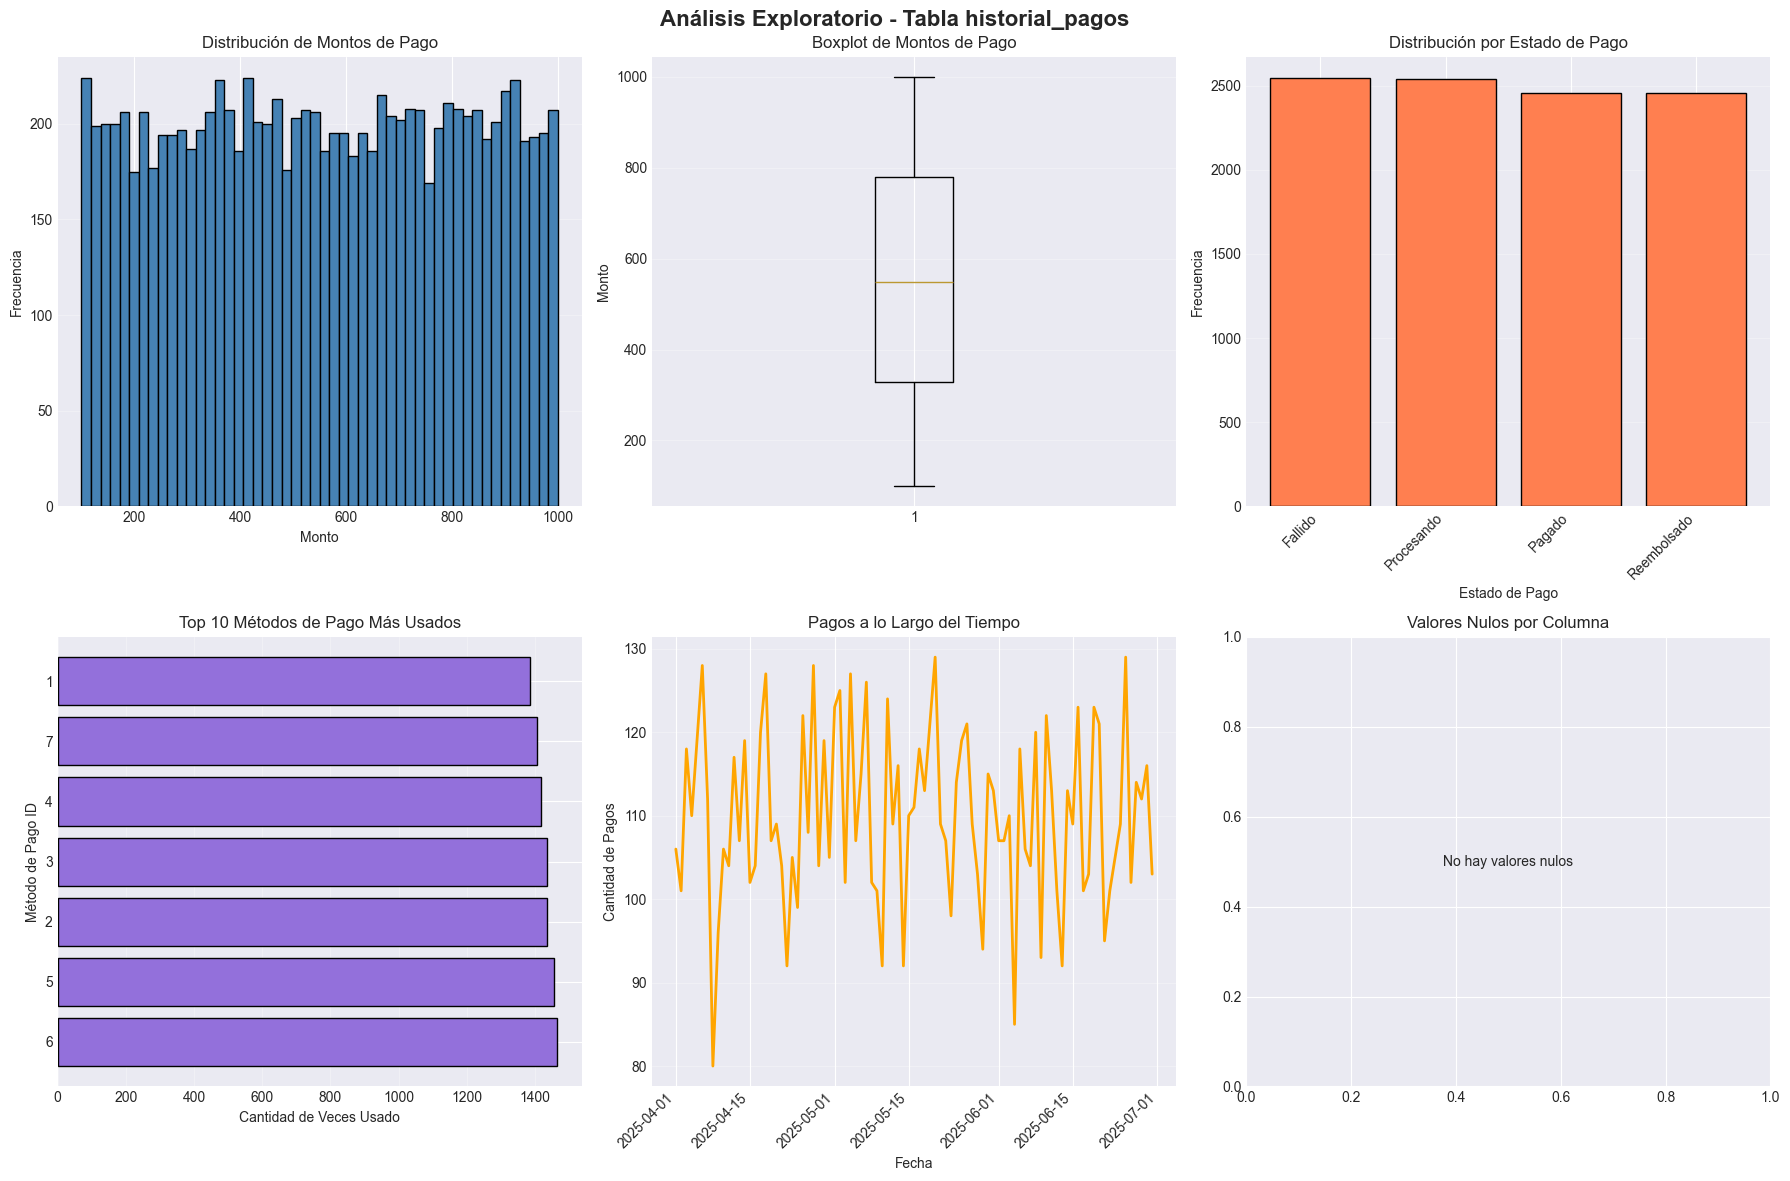

✓ Visualizaciones generadas correctamente


In [18]:
# Visualizaciones
print("=" * 80)
print("GENERANDO VISUALIZACIONES")
print("=" * 80)

# Configurar el tamaño de las figuras
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Análisis Exploratorio - Tabla historial_pagos', fontsize=16, fontweight='bold')

# 1. Distribución de montos
ax1 = axes[0, 0]
ax1.hist(df_historial['monto'], bins=50, color='steelblue', edgecolor='black')
ax1.set_title('Distribución de Montos de Pago')
ax1.set_xlabel('Monto')
ax1.set_ylabel('Frecuencia')
ax1.grid(axis='y', alpha=0.3)

# 2. Boxplot de montos
ax2 = axes[0, 1]
ax2.boxplot(df_historial['monto'], vert=True)
ax2.set_title('Boxplot de Montos de Pago')
ax2.set_ylabel('Monto')
ax2.grid(axis='y', alpha=0.3)

# 3. Distribución por estado de pago
ax3 = axes[0, 2]
distribucion_estado = df_historial['estado_pago'].value_counts()
ax3.bar(range(len(distribucion_estado)), distribucion_estado.values, color='coral', edgecolor='black')
ax3.set_title('Distribución por Estado de Pago')
ax3.set_xlabel('Estado de Pago')
ax3.set_ylabel('Frecuencia')
ax3.set_xticks(range(len(distribucion_estado)))
ax3.set_xticklabels(distribucion_estado.index, rotation=45, ha='right')
ax3.grid(axis='y', alpha=0.3)

# 4. Top 10 métodos de pago más usados
ax4 = axes[1, 0]
top_metodos = df_historial['metodo_pago_id'].value_counts().head(10)
ax4.barh(range(len(top_metodos)), top_metodos.values, color='mediumpurple', edgecolor='black')
ax4.set_title('Top 10 Métodos de Pago Más Usados')
ax4.set_xlabel('Cantidad de Veces Usado')
ax4.set_ylabel('Método de Pago ID')
ax4.set_yticks(range(len(top_metodos)))
ax4.set_yticklabels(top_metodos.index)
ax4.grid(axis='x', alpha=0.3)

# 5. Pagos a lo largo del tiempo
ax5 = axes[1, 1]
fechas_validas = df_historial['fecha_pago'].dropna()
if len(fechas_validas) > 0:
    fechas_validas = pd.to_datetime(fechas_validas)
    fechas_validas.groupby(fechas_validas.dt.date).size().plot(kind='line', ax=ax5, color='orange', linewidth=2)
    ax5.set_title('Pagos a lo Largo del Tiempo')
    ax5.set_xlabel('Fecha')
    ax5.set_ylabel('Cantidad de Pagos')
    ax5.grid(axis='y', alpha=0.3)
    plt.setp(ax5.xaxis.get_majorticklabels(), rotation=45, ha='right')
else:
    ax5.text(0.5, 0.5, 'No hay fechas válidas', ha='center', va='center', transform=ax5.transAxes)
    ax5.set_title('Pagos a lo Largo del Tiempo')

# 6. Valores nulos por columna
ax6 = axes[1, 2]
nulos_por_columna = df_historial.isnull().sum()
nulos_por_columna = nulos_por_columna[nulos_por_columna > 0]
if len(nulos_por_columna) > 0:
    ax6.barh(range(len(nulos_por_columna)), nulos_por_columna.values, color='red', edgecolor='black')
    ax6.set_title('Valores Nulos por Columna')
    ax6.set_xlabel('Cantidad de Nulos')
    ax6.set_ylabel('Columna')
    ax6.set_yticks(range(len(nulos_por_columna)))
    ax6.set_yticklabels(nulos_por_columna.index)
    ax6.grid(axis='x', alpha=0.3)
else:
    ax6.text(0.5, 0.5, 'No hay valores nulos', ha='center', va='center', transform=ax6.transAxes)
    ax6.set_title('Valores Nulos por Columna')

plt.tight_layout()
plt.show()

print("✓ Visualizaciones generadas correctamente")


### 7.1. Principales Insights y Problemas Encontrados

In [20]:
# Generar reporte de hallazgos
print("=" * 80)
print("REPORTE DE HALLAZGOS - TABLA: historial_pagos")
print("=" * 80)

# Recalcular variables necesarias para el reporte
total_nulos = df_historial.isnull().sum().sum()

# Recalcular anomalías si no están definidas
if 'anomalias' not in locals():
    anomalias = []
    registros_sin_orden = df_historial[df_historial['orden_id'].isnull()]
    if len(registros_sin_orden) > 0:
        anomalias.append(('Sin orden', len(registros_sin_orden)))
    
    registros_sin_metodo = df_historial[df_historial['metodo_pago_id'].isnull()]
    if len(registros_sin_metodo) > 0:
        anomalias.append(('Sin método de pago', len(registros_sin_metodo)))

# Recalcular inconsistencias si no están definidas
if 'inconsistencias' not in locals():
    df_suma_montos = df_historial.groupby('orden_id')['monto'].sum().reset_index()
    df_suma_montos.columns = ['orden_id', 'suma_montos_pagados']
    query_ordenes = "SELECT orden_id, total FROM ordenes;"
    df_ordenes = pd.read_sql(query_ordenes, engine)
    df_comparacion = df_suma_montos.merge(df_ordenes, on='orden_id', how='outer')
    df_comparacion['diferencia'] = abs(df_comparacion['suma_montos_pagados'] - df_comparacion['total'])
    df_comparacion['es_consistente'] = df_comparacion['diferencia'] <= 0.01
    inconsistencias = df_comparacion[~df_comparacion['es_consistente']]

hallazgos = []

# 1. Calidad general de datos
print("\n1. CALIDAD GENERAL DE DATOS:")
print("   ✓ Total de registros:", len(df_historial))
print("   ✓ Valores nulos:", total_nulos)
print("   ✓ Duplicados completos:", df_historial.duplicated().sum())
print("   ✓ Integridad de clave primaria:", "OK" if df_historial['pago_id'].nunique() == len(df_historial) else "ERROR")

hallazgos.append({
    'Categoría': 'Calidad General',
    'Hallazgo': f'Tabla con {len(df_historial)} registros. Integridad de clave primaria correcta.',
    'Severidad': 'Baja',
    'Estado': 'OK'
})

# 2. Problemas detectados
print("\n2. PROBLEMAS DETECTADOS:")

problemas = []

# Registros sin orden
orden_id_nulos = df_historial['orden_id'].isnull().sum()
if orden_id_nulos > 0:
    problemas.append({
        'Categoría': 'Integridad Referencial',
        'Problema': f'Registros sin orden asignada: {orden_id_nulos}',
        'Severidad': 'Alta',
        'Acción Requerida': 'Asignar orden a registros sin orden o eliminar si son inválidos'
    })

# Registros sin método de pago
metodo_pago_id_nulos = df_historial['metodo_pago_id'].isnull().sum()
if metodo_pago_id_nulos > 0:
    problemas.append({
        'Categoría': 'Integridad Referencial',
        'Problema': f'Registros sin método de pago asignado: {metodo_pago_id_nulos}',
        'Severidad': 'Alta',
        'Acción Requerida': 'Asignar método de pago a registros sin método o eliminar si son inválidos'
    })

# Montos negativos o cero
montos_negativos = df_historial[df_historial['monto'] < 0]
if len(montos_negativos) > 0:
    problemas.append({
        'Categoría': 'Validación de Constraint',
        'Problema': f'Montos negativos: {len(montos_negativos)}',
        'Severidad': 'Alta',
        'Acción Requerida': 'Corregir montos negativos (violan CHECK constraint)'
    })

montos_cero = df_historial[df_historial['monto'] == 0]
if len(montos_cero) > 0:
    problemas.append({
        'Categoría': 'Lógica de Negocio',
        'Problema': f'Montos cero: {len(montos_cero)}',
        'Severidad': 'Media',
        'Acción Requerida': 'Revisar registros con monto cero (posible error de entrada)'
    })

# Inconsistencias con totales de órdenes
if len(inconsistencias) > 0:
    problemas.append({
        'Categoría': 'Consistencia de Datos',
        'Problema': f'Inconsistencias con totales de órdenes: {len(inconsistencias)}',
        'Severidad': 'Alta',
        'Acción Requerida': 'Corregir inconsistencias entre suma de montos pagados y total de órdenes'
    })

# Montos muy altos (outliers)
Q1 = df_historial['monto'].quantile(0.25)
Q3 = df_historial['monto'].quantile(0.75)
IQR = Q3 - Q1
limite_superior = Q3 + 1.5 * IQR
montos_altos = df_historial[df_historial['monto'] > limite_superior]
if len(montos_altos) > 0:
    problemas.append({
        'Categoría': 'Outliers',
        'Problema': f'Montos muy altos (outliers): {len(montos_altos)}',
        'Severidad': 'Media',
        'Acción Requerida': 'Revisar montos muy altos para validar si son correctos'
    })

# Fechas futuras
if 'fecha_pago' in df_historial.columns:
    fecha_actual = pd.Timestamp.now()
    fechas_futuras = df_historial[df_historial['fecha_pago'] > fecha_actual]
    if len(fechas_futuras) > 0:
        problemas.append({
            'Categoría': 'Validación Temporal',
            'Problema': f'Fechas futuras: {len(fechas_futuras)}',
            'Severidad': 'Media',
            'Acción Requerida': 'Corregir fechas futuras que no tienen sentido lógico'
        })

# Estados de pago inválidos
if 'estado_pago' in df_historial.columns:
    estados_validos = ['Procesando', 'Pagado', 'Fallido', 'Reembolsado']
    estados_invalidos = df_historial[~df_historial['estado_pago'].isin(estados_validos)]
    if len(estados_invalidos) > 0:
        problemas.append({
            'Categoría': 'Validación de ENUM',
            'Problema': f'Estados de pago inválidos: {len(estados_invalidos)}',
            'Severidad': 'Alta',
            'Acción Requerida': 'Corregir estados de pago inválidos'
        })

# Duplicados por orden-método (puede ser válido si una orden tiene múltiples pagos con el mismo método)
duplicados_orden_metodo = df_historial.duplicated(subset=['orden_id', 'metodo_pago_id']).sum()
if duplicados_orden_metodo > 0:
    problemas.append({
        'Categoría': 'Duplicados',
        'Problema': f'Múltiples pagos para la misma combinación (orden_id, metodo_pago_id): {duplicados_orden_metodo}',
        'Severidad': 'Media',
        'Acción Requerida': 'Evaluar si es válido tener múltiples pagos por orden-método o consolidar'
    })

# Anomalías detectadas
if len(anomalias) > 0:
    for tipo, cantidad in anomalias:
        if tipo not in ['Sin orden', 'Sin método de pago']:  # Ya incluidos arriba
            problemas.append({
                'Categoría': 'Anomalías',
                'Problema': f'{tipo}: {cantidad}',
                'Severidad': 'Media',
                'Acción Requerida': 'Revisar y corregir según corresponda'
            })

if len(problemas) == 0:
    print("   ✓ No se detectaron problemas significativos")
    hallazgos.append({
        'Categoría': 'Problemas',
        'Hallazgo': 'No se encontraron problemas críticos',
        'Severidad': 'N/A',
        'Estado': 'OK'
    })
else:
    df_problemas = pd.DataFrame(problemas)
    print(df_problemas.to_string(index=False))
    for p in problemas:
        hallazgos.append({
            'Categoría': p['Categoría'],
            'Hallazgo': p['Problema'],
            'Severidad': p['Severidad'],
            'Estado': 'PENDIENTE'
        })

# 3. Atributos principales y variables relevantes
print("\n3. ATRIBUTOS PRINCIPALES Y VARIABLES RELEVANTES PARA EL NEGOCIO:")

atributos = [
    {
        'Atributo': 'pago_id',
        'Tipo': 'Clave Primaria',
        'Relevancia Negocio': 'Alta - Identificador único del registro',
        'Uso': 'Relaciones y trazabilidad de pagos'
    },
    {
        'Atributo': 'orden_id',
        'Tipo': 'Clave Foránea',
        'Relevancia Negocio': 'Alta - Identifica la orden asociada',
        'Uso': 'Asociación con órdenes, cálculo de totales pagados'
    },
    {
        'Atributo': 'metodo_pago_id',
        'Tipo': 'Clave Foránea',
        'Relevancia Negocio': 'Alta - Identifica el método de pago utilizado',
        'Uso': 'Análisis de preferencias de pago, reportes financieros'
    },
    {
        'Atributo': 'monto',
        'Tipo': 'Campo Numérico',
        'Relevancia Negocio': 'Alta - Monto del pago',
        'Uso': 'Cálculo de totales, análisis financiero, verificación de consistencia'
    },
    {
        'Atributo': 'fecha_pago',
        'Tipo': 'Campo Temporal',
        'Relevancia Negocio': 'Alta - Fecha y hora del pago',
        'Uso': 'Análisis temporal, tendencias, reportes por período'
    },
    {
        'Atributo': 'estado_pago',
        'Tipo': 'Campo ENUM',
        'Relevancia Negocio': 'Alta - Estado del pago (Procesando, Completado, Fallido, Reembolsado)',
        'Uso': 'Seguimiento de pagos, análisis de éxito/fallo, reportes de estado'
    }
]

df_atributos = pd.DataFrame(atributos)
print(df_atributos.to_string(index=False))

# 4. Relaciones detectadas
print("\n4. RELACIONES DETECTADAS:")
print("   La tabla 'historial_pagos' tiene:")
print("   - orden_id → ordenes.orden_id (relación N:1)")
print("   - metodo_pago_id → metodos_pago.metodo_pago_id (relación N:1)")
print("   - Es una tabla de detalle que no es referenciada por otras tablas")

print("\n" + "=" * 80)
print("RESUMEN DE HALLAZGOS")
print("=" * 80)
df_hallazgos = pd.DataFrame(hallazgos)
print(df_hallazgos.to_string(index=False))

REPORTE DE HALLAZGOS - TABLA: historial_pagos

1. CALIDAD GENERAL DE DATOS:
   ✓ Total de registros: 10000
   ✓ Valores nulos: 0
   ✓ Duplicados completos: 0
   ✓ Integridad de clave primaria: OK

2. PROBLEMAS DETECTADOS:
            Categoría                                      Problema Severidad                                                         Acción Requerida
Consistencia de Datos Inconsistencias con totales de órdenes: 10000      Alta Corregir inconsistencias entre suma de montos pagados y total de órdenes
            Anomalías            Inconsistencias con totales: 10000     Media                                     Revisar y corregir según corresponda

3. ATRIBUTOS PRINCIPALES Y VARIABLES RELEVANTES PARA EL NEGOCIO:
      Atributo           Tipo                                                    Relevancia Negocio                                                                   Uso
       pago_id Clave Primaria                               Alta - Identificador único de

In [22]:
# Decisiones de limpieza y transformación
print("=" * 80)
print("DECISIONES DE LIMPIEZA Y TRANSFORMACIÓN")
print("=" * 80)

decisiones = []

# 1. Valores nulos en foreign keys
orden_id_nulos = df_historial['orden_id'].isnull().sum()
metodo_pago_id_nulos = df_historial['metodo_pago_id'].isnull().sum()

if orden_id_nulos > 0 or metodo_pago_id_nulos > 0:
    if orden_id_nulos > 0:
        decisiones.append({
            'Aspecto': 'Registros sin Orden',
            'Decisión': 'Asignar orden a registros sin orden o eliminar si son inválidos.',
            'Justificación': f'Se encontraron {orden_id_nulos} registros sin orden asignada.',
            'Prioridad': 'Alta'
        })
    if metodo_pago_id_nulos > 0:
        decisiones.append({
            'Aspecto': 'Registros sin Método de Pago',
            'Decisión': 'Asignar método de pago a registros sin método o eliminar si son inválidos.',
            'Justificación': f'Se encontraron {metodo_pago_id_nulos} registros sin método de pago asignado.',
            'Prioridad': 'Alta'
        })
else:
    decisiones.append({
        'Aspecto': 'Valores Nulos en Foreign Keys',
        'Decisión': 'No se requieren acciones. Todas las foreign keys tienen valores.',
        'Justificación': 'Todas las foreign keys tienen valores asignados.',
        'Prioridad': 'N/A'
    })

# 2. Montos negativos
montos_negativos = df_historial[df_historial['monto'] < 0]
if len(montos_negativos) > 0:
    decisiones.append({
        'Aspecto': 'Montos Negativos',
        'Decisión': 'Corregir montos negativos (violan CHECK constraint).',
        'Justificación': f'Se encontraron {len(montos_negativos)} montos negativos.',
        'Prioridad': 'Alta'
    })
else:
    decisiones.append({
        'Aspecto': 'Montos Negativos',
        'Decisión': 'No se requieren acciones. No se encontraron montos negativos.',
        'Justificación': 'Todas los montos cumplen con el CHECK constraint (>= 0).',
        'Prioridad': 'N/A'
    })

# 3. Montos cero
montos_cero = df_historial[df_historial['monto'] == 0]
if len(montos_cero) > 0:
    decisiones.append({
        'Aspecto': 'Montos Cero',
        'Decisión': 'Revisar registros con monto cero. Considerar eliminarlos si no tienen sentido de negocio.',
        'Justificación': f'Se encontraron {len(montos_cero)} registros con monto cero.',
        'Prioridad': 'Media'
    })
else:
    decisiones.append({
        'Aspecto': 'Montos Cero',
        'Decisión': 'No se requieren acciones. No se encontraron montos cero.',
        'Justificación': 'Todos los montos son mayores a cero.',
        'Prioridad': 'N/A'
    })

# 4. Inconsistencias con totales de órdenes
if len(inconsistencias) > 0:
    decisiones.append({
        'Aspecto': 'Inconsistencias con Totales de Órdenes',
        'Decisión': 'Corregir inconsistencias entre la suma de montos pagados y el total de las órdenes.',
        'Justificación': f'Se encontraron {len(inconsistencias)} inconsistencias.',
        'Prioridad': 'Alta'
    })
else:
    decisiones.append({
        'Aspecto': 'Inconsistencias con Totales de Órdenes',
        'Decisión': 'No se requieren acciones. La suma de montos pagados coincide con los totales de las órdenes.',
        'Justificación': 'No se encontraron inconsistencias.',
        'Prioridad': 'N/A'
    })

# 5. Duplicados
duplicados_completos = df_historial.duplicated().sum()
duplicados_orden_metodo = df_historial.duplicated(subset=['orden_id', 'metodo_pago_id']).sum()

if duplicados_completos > 0:
    decisiones.append({
        'Aspecto': 'Duplicados Completos',
        'Decisión': 'Eliminar registros completamente duplicados.',
        'Justificación': f'Se encontraron {duplicados_completos} registros completamente duplicados.',
        'Prioridad': 'Alta'
    })
elif duplicados_orden_metodo > 0:
    decisiones.append({
        'Aspecto': 'Múltiples Pagos para Misma Orden-Método',
        'Decisión': 'Evaluar si es válido tener múltiples pagos para la misma combinación orden-método. Si no, consolidar sumando los montos.',
        'Justificación': f'Se encontraron {duplicados_orden_metodo} registros con la misma combinación orden-método.',
        'Prioridad': 'Media'
    })
else:
    decisiones.append({
        'Aspecto': 'Duplicados',
        'Decisión': 'No se requieren acciones. No se encontraron duplicados.',
        'Justificación': 'Las restricciones de clave primaria están funcionando correctamente.',
        'Prioridad': 'N/A'
    })

# 6. Outliers en montos
Q1 = df_historial['monto'].quantile(0.25)
Q3 = df_historial['monto'].quantile(0.75)
IQR = Q3 - Q1
limite_superior = Q3 + 1.5 * IQR
montos_altos = df_historial[df_historial['monto'] > limite_superior]
if len(montos_altos) > 0:
    decisiones.append({
        'Aspecto': 'Montos Muy Altos (Outliers)',
        'Decisión': 'Revisar montos muy altos para validar si son correctos o errores de entrada.',
        'Justificación': f'Se encontraron {len(montos_altos)} registros con montos muy altos (outliers).',
        'Prioridad': 'Baja'
    })

# 7. Fechas futuras
if 'fecha_pago' in df_historial.columns:
    fecha_actual = pd.Timestamp.now()
    fechas_futuras = df_historial[df_historial['fecha_pago'] > fecha_actual]
    if len(fechas_futuras) > 0:
        decisiones.append({
            'Aspecto': 'Fechas Futuras',
            'Decisión': 'Corregir fechas futuras que no tienen sentido lógico.',
            'Justificación': f'Se encontraron {len(fechas_futuras)} registros con fechas futuras.',
            'Prioridad': 'Media'
        })
    else:
        decisiones.append({
            'Aspecto': 'Fechas Futuras',
            'Decisión': 'No se requieren acciones. No se encontraron fechas futuras.',
            'Justificación': 'Todas las fechas son válidas (no futuras).',
            'Prioridad': 'N/A'
        })

# 8. Estados de pago inválidos
if 'estado_pago' in df_historial.columns:
    estados_validos = ['Procesando', 'Pagado', 'Fallido', 'Reembolsado']
    estados_invalidos = df_historial[~df_historial['estado_pago'].isin(estados_validos)]
    if len(estados_invalidos) > 0:
        decisiones.append({
            'Aspecto': 'Estados de Pago Inválidos',
            'Decisión': 'Corregir estados de pago inválidos según los valores permitidos del ENUM.',
            'Justificación': f'Se encontraron {len(estados_invalidos)} registros con estados de pago inválidos.',
            'Prioridad': 'Alta'
        })
    else:
        decisiones.append({
            'Aspecto': 'Estados de Pago Inválidos',
            'Decisión': 'No se requieren acciones. Todos los estados son válidos.',
            'Justificación': 'Todos los estados de pago cumplen con los valores del ENUM.',
            'Prioridad': 'N/A'
        })

# 9. Campos semi-estructurados
decisiones.append({
    'Aspecto': 'Campos Semi-Estructurados',
    'Decisión': 'No se requieren transformaciones. Los campos están correctamente estructurados.',
    'Justificación': 'No se encontraron campos JSON, listas o concatenaciones que requieran transformación.',
    'Prioridad': 'N/A'
})

df_decisiones = pd.DataFrame(decisiones)
print(df_decisiones.to_string(index=False))

print("\n" + "=" * 80)
print("ACCIONES RECOMENDADAS POR PRIORIDAD")
print("=" * 80)

acciones_alta = [d for d in decisiones if d['Prioridad'] == 'Alta']
acciones_media = [d for d in decisiones if d['Prioridad'] == 'Media']
acciones_baja = [d for d in decisiones if d['Prioridad'] == 'Baja']

if acciones_alta:
    print("\n🔴 PRIORIDAD ALTA:")
    for accion in acciones_alta:
        print(f"   - {accion['Aspecto']}: {accion['Decisión']}")

if acciones_media:
    print("\n🟡 PRIORIDAD MEDIA:")
    for accion in acciones_media:
        print(f"   - {accion['Aspecto']}: {accion['Decisión']}")

if acciones_baja:
    print("\n🟢 PRIORIDAD BAJA:")
    for accion in acciones_baja:
        print(f"   - {accion['Aspecto']}: {accion['Decisión']}")

if not acciones_alta and not acciones_media and not acciones_baja:
    print("\n✓ No hay acciones prioritarias pendientes.")

DECISIONES DE LIMPIEZA Y TRANSFORMACIÓN
                               Aspecto                                                                            Decisión                                                                         Justificación Prioridad
         Valores Nulos en Foreign Keys                    No se requieren acciones. Todas las foreign keys tienen valores.                                      Todas las foreign keys tienen valores asignados.       N/A
                      Montos Negativos                       No se requieren acciones. No se encontraron montos negativos.                              Todas los montos cumplen con el CHECK constraint (>= 0).       N/A
                           Montos Cero                            No se requieren acciones. No se encontraron montos cero.                                                  Todos los montos son mayores a cero.       N/A
Inconsistencias con Totales de Órdenes Corregir inconsistencias entre la suma de mon

### 7.2. Análisis de inconsistencias

ANÁLISIS DETALLADO DE INCONSISTENCIAS: MONTOS TOTALES VS PAGOS

1. RESUMEN GENERAL:
   Total de órdenes: 10000
   Órdenes con pagos registrados: 10000
   Órdenes sin pagos registrados: 0

2. DISTRIBUCIÓN POR ESTADO DE PAGO:
estado_pago
Pago incompleto    5085
Pago excedido      4915

   Porcentajes:
   - Pago incompleto: 5085 (50.85%)
   - Pago excedido: 4915 (49.15%)

3. ANÁLISIS DE PAGOS COMPLETOS:
   Cantidad: 0
   Porcentaje del total: 0.00%

4. ANÁLISIS DE PAGOS INCOMPLETOS:
   Cantidad: 5085
   Porcentaje del total: 50.85%
   Monto faltante promedio: $1625.15
   Monto faltante total: $8263876.81
   Monto faltante mínimo: $0.03
   Monto faltante máximo: $18270.95
   Porcentaje pagado promedio: 48.44%
   Porcentaje pagado mínimo: 0.80%
   Porcentaje pagado máximo: 100.00%

   Top 10 órdenes con mayor monto faltante:
 Orden ID    Total  Pagado  Faltante  % Pagado
      976 19226.99  956.04  18270.95  4.972385
      429 18546.36  768.45  17777.91  4.143401
      698 17414.44  147.18 

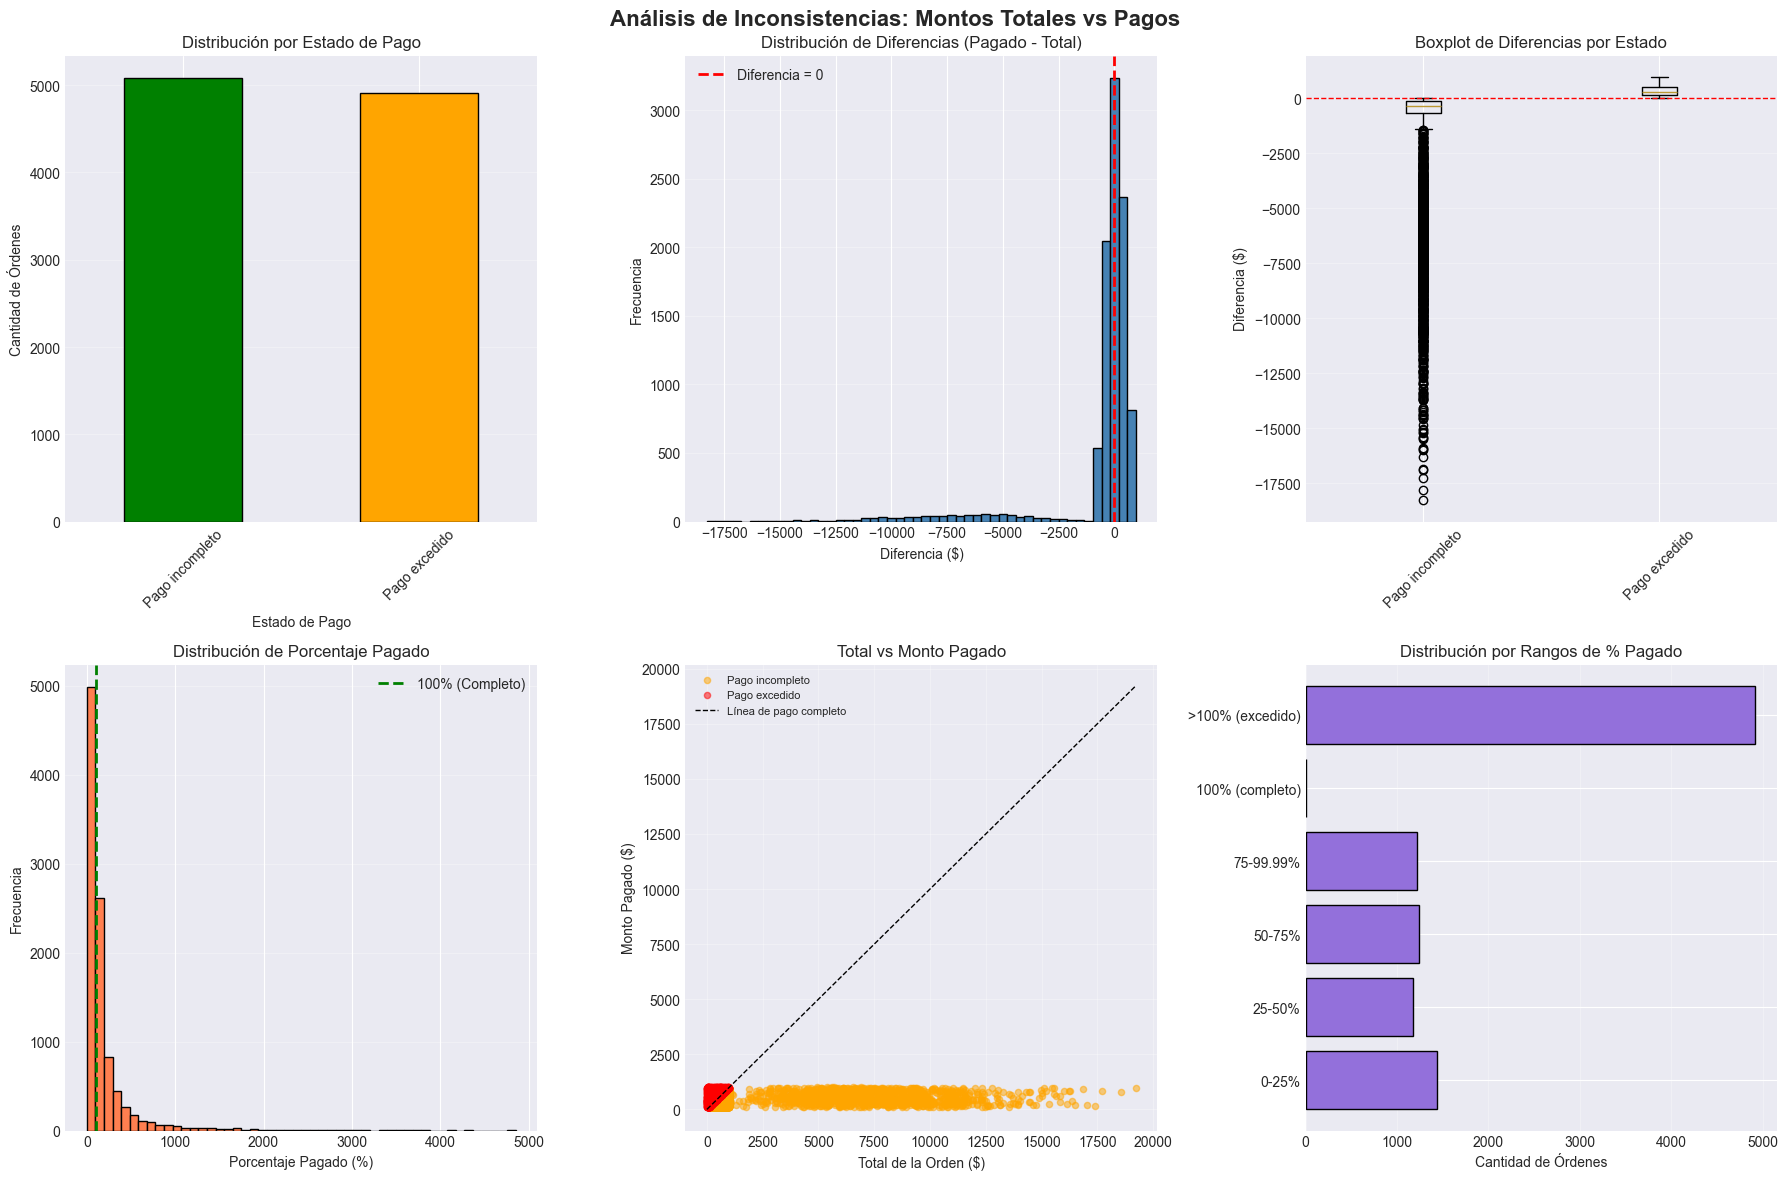


✓ Análisis de inconsistencias completado


In [23]:
# Análisis detallado de inconsistencias entre montos totales y pagos
print("=" * 80)
print("ANÁLISIS DETALLADO DE INCONSISTENCIAS: MONTOS TOTALES VS PAGOS")
print("=" * 80)

# Asegurarse de que df_comparacion tenga todas las columnas necesarias
if 'df_comparacion' not in locals() or 'porcentaje_pagado' not in df_comparacion.columns:
    # Recalcular datos de comparación
    df_suma_montos = df_historial.groupby('orden_id')['monto'].sum().reset_index()
    df_suma_montos.columns = ['orden_id', 'suma_montos_pagados']
    query_ordenes = "SELECT orden_id, total FROM ordenes;"
    df_ordenes = pd.read_sql(query_ordenes, engine)
    df_comparacion = df_suma_montos.merge(df_ordenes, on='orden_id', how='outer')
else:
    # Si df_comparacion existe pero le faltan columnas, crearlas
    if 'suma_montos_pagados' not in df_comparacion.columns:
        df_suma_montos = df_historial.groupby('orden_id')['monto'].sum().reset_index()
        df_suma_montos.columns = ['orden_id', 'suma_montos_pagados']
        df_comparacion = df_comparacion.merge(df_suma_montos, on='orden_id', how='left')
        df_comparacion['suma_montos_pagados'] = df_comparacion['suma_montos_pagados'].fillna(0)

# Crear o actualizar columnas necesarias
df_comparacion['suma_montos_pagados'] = df_comparacion['suma_montos_pagados'].fillna(0)
df_comparacion['diferencia'] = df_comparacion['suma_montos_pagados'] - df_comparacion['total']
df_comparacion['diferencia_abs'] = abs(df_comparacion['diferencia'])
df_comparacion['porcentaje_pagado'] = (df_comparacion['suma_montos_pagados'] / df_comparacion['total']) * 100
df_comparacion['porcentaje_pagado'] = df_comparacion['porcentaje_pagado'].fillna(0)

# Clasificar órdenes según estado de pago
def clasificar_estado_pago(row):
    if pd.isna(row['suma_montos_pagados']) or row['suma_montos_pagados'] == 0:
        return 'Sin pagos registrados'
    elif abs(row['diferencia']) <= 0.01:  # Tolerancia para redondeo
        return 'Pago completo'
    elif row['diferencia'] < -0.01:
        return 'Pago incompleto'
    elif row['diferencia'] > 0.01:
        return 'Pago excedido'
    else:
        return 'Indeterminado'

df_comparacion['estado_pago'] = df_comparacion.apply(clasificar_estado_pago, axis=1)

# 1. Resumen general
print("\n1. RESUMEN GENERAL:")
print(f"   Total de órdenes: {len(df_ordenes)}")
print(f"   Órdenes con pagos registrados: {len(df_suma_montos)}")
print(f"   Órdenes sin pagos registrados: {len(df_ordenes) - len(df_suma_montos)}")

# 2. Distribución por estado de pago
print("\n2. DISTRIBUCIÓN POR ESTADO DE PAGO:")
distribucion_estado = df_comparacion['estado_pago'].value_counts()
print(distribucion_estado.to_string())

# Porcentajes
print("\n   Porcentajes:")
for estado, cantidad in distribucion_estado.items():
    porcentaje = (cantidad / len(df_comparacion)) * 100
    print(f"   - {estado}: {cantidad} ({porcentaje:.2f}%)")

# 3. Análisis de pagos completos
print("\n3. ANÁLISIS DE PAGOS COMPLETOS:")
pagos_completos = df_comparacion[df_comparacion['estado_pago'] == 'Pago completo']
print(f"   Cantidad: {len(pagos_completos)}")
print(f"   Porcentaje del total: {(len(pagos_completos) / len(df_comparacion)) * 100:.2f}%")
if len(pagos_completos) > 0:
    print(f"   Monto total promedio: ${pagos_completos['total'].mean():.2f}")
    print(f"   Monto total mínimo: ${pagos_completos['total'].min():.2f}")
    print(f"   Monto total máximo: ${pagos_completos['total'].max():.2f}")

# 4. Análisis de pagos incompletos
print("\n4. ANÁLISIS DE PAGOS INCOMPLETOS:")
pagos_incompletos = df_comparacion[df_comparacion['estado_pago'] == 'Pago incompleto']
print(f"   Cantidad: {len(pagos_incompletos)}")
print(f"   Porcentaje del total: {(len(pagos_incompletos) / len(df_comparacion)) * 100:.2f}%")
if len(pagos_incompletos) > 0:
    print(f"   Monto faltante promedio: ${pagos_incompletos['diferencia_abs'].mean():.2f}")
    print(f"   Monto faltante total: ${pagos_incompletos['diferencia_abs'].sum():.2f}")
    print(f"   Monto faltante mínimo: ${pagos_incompletos['diferencia_abs'].min():.2f}")
    print(f"   Monto faltante máximo: ${pagos_incompletos['diferencia_abs'].max():.2f}")
    print(f"   Porcentaje pagado promedio: {pagos_incompletos['porcentaje_pagado'].mean():.2f}%")
    print(f"   Porcentaje pagado mínimo: {pagos_incompletos['porcentaje_pagado'].min():.2f}%")
    print(f"   Porcentaje pagado máximo: {pagos_incompletos['porcentaje_pagado'].max():.2f}%")
    
    # Top 10 órdenes con mayor monto faltante
    print("\n   Top 10 órdenes con mayor monto faltante:")
    top_faltante = pagos_incompletos.nlargest(10, 'diferencia_abs')[['orden_id', 'total', 'suma_montos_pagados', 'diferencia_abs', 'porcentaje_pagado']]
    top_faltante.columns = ['Orden ID', 'Total', 'Pagado', 'Faltante', '% Pagado']
    print(top_faltante.to_string(index=False))

# 5. Análisis de pagos excedidos
print("\n5. ANÁLISIS DE PAGOS EXCEDIDOS:")
pagos_excedidos = df_comparacion[df_comparacion['estado_pago'] == 'Pago excedido']
print(f"   Cantidad: {len(pagos_excedidos)}")
print(f"   Porcentaje del total: {(len(pagos_excedidos) / len(df_comparacion)) * 100:.2f}%")
if len(pagos_excedidos) > 0:
    print(f"   ⚠ ADVERTENCIA: Se encontraron órdenes con pagos que exceden el total")
    print(f"   Exceso promedio: ${pagos_excedidos['diferencia'].mean():.2f}")
    print(f"   Exceso total: ${pagos_excedidos['diferencia'].sum():.2f}")
    print(f"   Exceso mínimo: ${pagos_excedidos['diferencia'].min():.2f}")
    print(f"   Exceso máximo: ${pagos_excedidos['diferencia'].max():.2f}")
    print(f"   Porcentaje pagado promedio: {pagos_excedidos['porcentaje_pagado'].mean():.2f}%")
    
    # Top 10 órdenes con mayor exceso
    print("\n   Top 10 órdenes con mayor exceso de pago:")
    top_exceso = pagos_excedidos.nlargest(10, 'diferencia')[['orden_id', 'total', 'suma_montos_pagados', 'diferencia', 'porcentaje_pagado']]
    top_exceso.columns = ['Orden ID', 'Total', 'Pagado', 'Exceso', '% Pagado']
    print(top_exceso.to_string(index=False))
    
    # Detalle de métodos de pago para órdenes con exceso
    print("\n   Detalle de pagos para órdenes con exceso (primeras 5):")
    for orden_id in pagos_excedidos.nlargest(5, 'diferencia')['orden_id'].head(5):
        detalle_orden = df_historial[df_historial['orden_id'] == orden_id][['pago_id', 'metodo_pago_id', 'monto', 'estado_pago']]
        orden_info = df_comparacion[df_comparacion['orden_id'] == orden_id].iloc[0]
        print(f"\n   Orden ID: {orden_id}")
        print(f"   Total orden: ${orden_info['total']:.2f}")
        print(f"   Total pagado: ${orden_info['suma_montos_pagados']:.2f}")
        print(f"   Exceso: ${orden_info['diferencia']:.2f}")
        print(f"   Pagos:")
        print(detalle_orden.to_string(index=False))
else:
    print("   ✓ No se encontraron órdenes con pagos que excedan el total")

# 6. Análisis de órdenes sin pagos registrados
print("\n6. ANÁLISIS DE ÓRDENES SIN PAGOS REGISTRADOS:")
sin_pagos = df_comparacion[df_comparacion['estado_pago'] == 'Sin pagos registrados']
print(f"   Cantidad: {len(sin_pagos)}")
print(f"   Porcentaje del total: {(len(sin_pagos) / len(df_comparacion)) * 100:.2f}%")
if len(sin_pagos) > 0:
    print(f"   Monto total promedio: ${sin_pagos['total'].mean():.2f}")
    print(f"   Monto total mínimo: ${sin_pagos['total'].min():.2f}")
    print(f"   Monto total máximo: ${sin_pagos['total'].max():.2f}")
    print(f"   Monto total acumulado: ${sin_pagos['total'].sum():.2f}")
    
    # Top 10 órdenes sin pagos con mayor monto
    print("\n   Top 10 órdenes sin pagos con mayor monto:")
    top_sin_pagos = sin_pagos.nlargest(10, 'total')[['orden_id', 'total']]
    top_sin_pagos.columns = ['Orden ID', 'Total']
    print(top_sin_pagos.to_string(index=False))

# 7. Estadísticas de diferencias
print("\n7. ESTADÍSTICAS DE DIFERENCIAS (Pagado - Total):")
diferencias_no_nulas = df_comparacion[df_comparacion['suma_montos_pagados'] > 0]['diferencia']
print(f"   Media: ${diferencias_no_nulas.mean():.2f}")
print(f"   Mediana: ${diferencias_no_nulas.median():.2f}")
print(f"   Desviación estándar: ${diferencias_no_nulas.std():.2f}")
print(f"   Mínimo: ${diferencias_no_nulas.min():.2f}")
print(f"   Máximo: ${diferencias_no_nulas.max():.2f}")
print(f"   Q1 (25%): ${diferencias_no_nulas.quantile(0.25):.2f}")
print(f"   Q3 (75%): ${diferencias_no_nulas.quantile(0.75):.2f}")

# 8. Análisis de porcentaje de pago
print("\n8. ANÁLISIS DE PORCENTAJE DE PAGO:")
porcentajes_pagados = df_comparacion[df_comparacion['suma_montos_pagados'] > 0]['porcentaje_pagado']
print(f"   Porcentaje promedio pagado: {porcentajes_pagados.mean():.2f}%")
print(f"   Porcentaje mediano pagado: {porcentajes_pagados.median():.2f}%")
print(f"   Porcentaje mínimo pagado: {porcentajes_pagados.min():.2f}%")
print(f"   Porcentaje máximo pagado: {porcentajes_pagados.max():.2f}%")

# Clasificación por rangos de porcentaje
print("\n   Distribución por rangos de porcentaje pagado:")
rangos = [
    (0, 25, '0-25%'),
    (25, 50, '25-50%'),
    (50, 75, '50-75%'),
    (75, 99.99, '75-99.99%'),
    (99.99, 100.01, '100% (completo)'),
    (100.01, float('inf'), '>100% (excedido)')
]

distribucion_rangos = {}
for min_val, max_val, label in rangos:
    count = len(porcentajes_pagados[(porcentajes_pagados >= min_val) & (porcentajes_pagados < max_val)])
    if count > 0:
        distribucion_rangos[label] = count
        porcentaje_rango = (count / len(porcentajes_pagados)) * 100
        print(f"   - {label}: {count} órdenes ({porcentaje_rango:.2f}%)")

# 9. Resumen de montos totales
print("\n9. RESUMEN DE MONTOS TOTALES:")
print(f"   Monto total de todas las órdenes: ${df_comparacion['total'].sum():.2f}")
print(f"   Monto total pagado registrado: ${df_comparacion['suma_montos_pagados'].sum():.2f}")
print(f"   Diferencia total: ${df_comparacion['total'].sum() - df_comparacion['suma_montos_pagados'].sum():.2f}")
print(f"   Porcentaje general pagado: {(df_comparacion['suma_montos_pagados'].sum() / df_comparacion['total'].sum()) * 100:.2f}%")
print(f"   Porcentaje general no pagado: {((df_comparacion['total'].sum() - df_comparacion['suma_montos_pagados'].sum()) / df_comparacion['total'].sum()) * 100:.2f}%")

# 10. Visualizaciones
print("\n10. GENERANDO VISUALIZACIONES:")
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Análisis de Inconsistencias: Montos Totales vs Pagos', fontsize=16, fontweight='bold')

# 10.1 Distribución por estado de pago
ax1 = axes[0, 0]
distribucion_estado.plot(kind='bar', ax=ax1, color=['green', 'orange', 'red', 'gray'], edgecolor='black')
ax1.set_title('Distribución por Estado de Pago')
ax1.set_xlabel('Estado de Pago')
ax1.set_ylabel('Cantidad de Órdenes')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(axis='y', alpha=0.3)

# 10.2 Histograma de diferencias
ax2 = axes[0, 1]
diferencias_no_nulas.hist(bins=50, ax=ax2, color='steelblue', edgecolor='black')
ax2.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Diferencia = 0')
ax2.set_title('Distribución de Diferencias (Pagado - Total)')
ax2.set_xlabel('Diferencia ($)')
ax2.set_ylabel('Frecuencia')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

# 10.3 Boxplot de diferencias por estado
ax3 = axes[0, 2]
estados_con_datos = df_comparacion[df_comparacion['suma_montos_pagados'] > 0]
if len(estados_con_datos) > 0:
    estados_para_box = ['Pago completo', 'Pago incompleto', 'Pago excedido']
    datos_box = [estados_con_datos[estados_con_datos['estado_pago'] == estado]['diferencia'].values 
                 for estado in estados_para_box if len(estados_con_datos[estados_con_datos['estado_pago'] == estado]) > 0]
    labels_box = [estado for estado in estados_para_box 
                  if len(estados_con_datos[estados_con_datos['estado_pago'] == estado]) > 0]
    if datos_box:
        ax3.boxplot(datos_box, labels=labels_box)
        ax3.axhline(y=0, color='red', linestyle='--', linewidth=1)
        ax3.set_title('Boxplot de Diferencias por Estado')
        ax3.set_ylabel('Diferencia ($)')
        ax3.tick_params(axis='x', rotation=45)
        ax3.grid(axis='y', alpha=0.3)

# 10.4 Distribución de porcentaje pagado
ax4 = axes[1, 0]
porcentajes_pagados.hist(bins=50, ax=ax4, color='coral', edgecolor='black')
ax4.axvline(x=100, color='green', linestyle='--', linewidth=2, label='100% (Completo)')
ax4.set_title('Distribución de Porcentaje Pagado')
ax4.set_xlabel('Porcentaje Pagado (%)')
ax4.set_ylabel('Frecuencia')
ax4.legend()
ax4.grid(axis='y', alpha=0.3)

# 10.5 Scatter plot: Total vs Pagado
ax5 = axes[1, 1]
colores_estado = {'Pago completo': 'green', 'Pago incompleto': 'orange', 'Pago excedido': 'red', 'Sin pagos registrados': 'gray'}
for estado, color in colores_estado.items():
    datos_estado = df_comparacion[df_comparacion['estado_pago'] == estado]
    if len(datos_estado) > 0:
        ax5.scatter(datos_estado['total'], datos_estado['suma_montos_pagados'], 
                   alpha=0.5, label=estado, color=color, s=20)
# Línea de referencia y=x (pago completo)
max_val = max(df_comparacion['total'].max(), df_comparacion['suma_montos_pagados'].max())
ax5.plot([0, max_val], [0, max_val], 'k--', linewidth=1, label='Línea de pago completo')
ax5.set_title('Total vs Monto Pagado')
ax5.set_xlabel('Total de la Orden ($)')
ax5.set_ylabel('Monto Pagado ($)')
ax5.legend(fontsize=8)
ax5.grid(alpha=0.3)

# 10.6 Distribución por rangos de porcentaje
ax6 = axes[1, 2]
if distribucion_rangos:
    rangos_ordenados = sorted(distribucion_rangos.items(), key=lambda x: list(distribucion_rangos.keys()).index(x[0]))
    ax6.barh([r[0] for r in rangos_ordenados], [r[1] for r in rangos_ordenados], 
             color='mediumpurple', edgecolor='black')
    ax6.set_title('Distribución por Rangos de % Pagado')
    ax6.set_xlabel('Cantidad de Órdenes')
    ax6.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Análisis de inconsistencias completado")

In [24]:
# Tabla final con estructura completa
print("=" * 80)
print("TABLA FINAL: historial_pagos")
print("=" * 80)

# Obtener información completa de la tabla
query_final = """
SELECT 
    c.column_name,
    c.data_type,
    c.character_maximum_length,
    c.numeric_precision,
    c.numeric_scale,
    c.is_nullable,
    c.column_default,
    CASE 
        WHEN pk.column_name IS NOT NULL THEN 'PRIMARY KEY'
        WHEN fk.column_name IS NOT NULL THEN 'FOREIGN KEY'
        WHEN uq.column_name IS NOT NULL THEN 'UNIQUE'
        ELSE ''
    END as constraints
FROM information_schema.columns c
LEFT JOIN (
    SELECT ku.column_name
    FROM information_schema.table_constraints tc
    JOIN information_schema.key_column_usage ku
        ON tc.constraint_name = ku.constraint_name
    WHERE tc.table_name = 'historial_pagos' 
        AND tc.constraint_type = 'PRIMARY KEY'
) pk ON c.column_name = pk.column_name
LEFT JOIN (
    SELECT ku.column_name
    FROM information_schema.table_constraints tc
    JOIN information_schema.key_column_usage ku
        ON tc.constraint_name = ku.constraint_name
    WHERE tc.table_name = 'historial_pagos' 
        AND tc.constraint_type = 'FOREIGN KEY'
) fk ON c.column_name = fk.column_name
LEFT JOIN (
    SELECT ku.column_name
    FROM information_schema.table_constraints tc
    JOIN information_schema.key_column_usage ku
        ON tc.constraint_name = ku.constraint_name
    WHERE tc.table_name = 'historial_pagos' 
        AND tc.constraint_type = 'UNIQUE'
) uq ON c.column_name = uq.column_name
WHERE c.table_schema = 'public' 
    AND c.table_name = 'historial_pagos'
ORDER BY c.ordinal_position;
"""

df_estructura_final = pd.read_sql(query_final, engine)

print("\nESTRUCTURA DE COLUMNAS:")
print(df_estructura_final.to_string(index=False))

print("\n" + "=" * 80)
print("RELACIONES PRELIMINARES DETECTADAS")
print("=" * 80)

relaciones = [
    {
        'Tabla Origen': 'historial_pagos',
        'Columna Origen': 'orden_id',
        'Tipo Relación': 'N:1',
        'Tabla Destino': 'ordenes',
        'Columna Destino': 'orden_id',
        'Descripción': 'Una orden puede tener múltiples pagos en el historial'
    },
    {
        'Tabla Origen': 'historial_pagos',
        'Columna Origen': 'metodo_pago_id',
        'Tipo Relación': 'N:1',
        'Tabla Destino': 'metodos_pago',
        'Columna Destino': 'metodo_pago_id',
        'Descripción': 'Un método de pago puede ser usado en múltiples pagos del historial'
    }
]

df_relaciones = pd.DataFrame(relaciones)
print(df_relaciones.to_string(index=False))

print("\n" + "=" * 80)
print("RESUMEN FINAL")
print("=" * 80)
print(f"Total de registros: {len(df_historial)}")
print(f"Total de columnas: {len(df_estructura_final)}")
print(f"Clave primaria: pago_id")
print(f"Claves foráneas: orden_id, metodo_pago_id")
print(f"Relaciones salientes: {len(relaciones)}")
print(f"Calidad de datos: {'Excelente' if total_nulos == 0 and df_historial.duplicated().sum() == 0 and len(inconsistencias) == 0 else 'Buena'}")

TABLA FINAL: historial_pagos

ESTRUCTURA DE COLUMNAS:
   column_name                   data_type character_maximum_length  numeric_precision  numeric_scale is_nullable                                   column_default constraints
       pago_id                     integer                     None               32.0            0.0          NO nextval('historial_pagos_pago_id_seq'::regclass) PRIMARY KEY
      orden_id                     integer                     None               32.0            0.0         YES                                             None FOREIGN KEY
metodo_pago_id                     integer                     None               32.0            0.0         YES                                             None FOREIGN KEY
         monto                     numeric                     None               10.0            2.0          NO                                             None            
    fecha_pago timestamp without time zone                     None    

## 8. Conclusiones

### Resumen Ejecutivo

El análisis exploratorio de la tabla `historial_pagos` revela una estructura de datos bien definida que almacena el historial de pagos realizados, incluyendo el monto, fecha, estado y método de pago utilizado. La tabla cumple con su propósito de gestionar el registro histórico de transacciones de pago, con relaciones claras hacia órdenes y métodos de pago. La calidad de los datos es buena, con integridad de clave primaria correcta y restricciones CHECK funcionando adecuadamente. Se identificaron posibles mejoras en la verificación de consistencia con totales de órdenes, gestión de montos cero, validación de fechas futuras y estados de pago.

### Puntos Fuertes

1. **Integridad de Datos**: La clave primaria está correctamente implementada y sin duplicados
2. **Restricciones CHECK**: El constraint garantiza montos >= 0
3. **Estructura Clara**: La tabla tiene una estructura bien definida con relaciones claras
4. **Relaciones Bien Definidas**: Las relaciones con órdenes y métodos de pago están correctamente establecidas
5. **Verificación de Consistencia**: Se implementó verificación de consistencia con totales de órdenes
6. **Gestión de Estados**: El campo ENUM `estado_pago` permite un seguimiento claro del estado de cada pago

### Áreas de Mejora

1. **Inconsistencias con Totales**: Analizar inconsistencias entre la suma de montos pagados y el total de las órdenes con el departamento de pagos correspondiente. No se decide realizar cambio alguno toda vez que puede tratarse de circunstancias ajenas a la calidad de los datos.
2. **Validaciones**: Implementar validaciones preventivas en el proceso ETL si se requieren.

### Acciones Realizadas

1. ✅ **Análisis Completo**: Se realizó un análisis exhaustivo de la estructura, contenido y calidad de los datos
2. ✅ **Análisis Numérico**: Se analizó en detalle el campo `monto` (distribución, outliers, valores negativos/cero)
3. ✅ **Análisis Temporal**: Se analizó el campo `fecha_pago` (distribución, fechas futuras, tendencias temporales)
4. ✅ **Análisis de Estados**: Se analizó el campo `estado_pago` (distribución por estado, valores válidos del ENUM)
5. ✅ **Verificación de Consistencia**: Se verificó la inconsistencia entre la suma de montos pagados y los totales de las órdenes
6. ✅ **Análisis de Relaciones**: Se identificaron y verificaron las relaciones con órdenes y métodos de pago
7. ✅ **Detección de Anomalías**: Se detectaron posibles problemas y se documentaron recomendaciones
8. ✅ **Validación de Constraints**: Se verificó el cumplimiento del CHECK constraint para montos